## Ultrasound images classification using ResNet18

In [95]:
import PIL
from PIL import Image
import os
import zipfile
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import torch
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

### Data

Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

### Preprocess

I have downloaded the dataset from kaggle. Dataset was not seperated to train/test so I've created some functions in order to split it by given ratio. Also, data included mask images that I have seperated and used only ultrasound images.
Ultrasound images in the dataset were given in a different size so I resized and center-cropped it to fit to ResNet18 input size.
Dataset has different amount of images per class so I checked which class has the minimum number of images ('normal' - 133 imags) and set this number * ratio (106) to be number of images of one class of train set. total number of train set images is (106*3=318). The rest moved for test set. (it makes sense for me that train should have equal number of images per class)

In [2]:
#Extract dataset
main_path=os.getcwd()
zip_file_path = '{}/archive.zip'.format(main_path)
target_dir = '{}/dataset'.format(main_path)

In [3]:
with zipfile.ZipFile(zip_file_path) as zf:
     for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, target_dir)
        except zipfile.error as e:
            pass

Extracting : 100%|█████████████████████████| 1578/1578 [00:02<00:00, 575.90it/s]


In [4]:
#Print dataset directory
def print_dir_hir(path):
    for dirpath, dirnames, filenames in os.walk(path):
        directory_level = dirpath.replace(path, "")
        directory_level = directory_level.count(os.sep)
        indent = " " * 4
        print("{}{}/".format(indent*directory_level, os.path.basename(dirpath)))

In [5]:
dataset_path=main_path+'/dataset'
print_dir_hir(dataset_path)

dataset/
    Dataset_BUSI_with_GT/
        malignant/
        benign/
        normal/


In [59]:
#Few specific functions for dataset directory hierarchy
def move_files_by_str(source_dir,dest_dir,substr):
    for top, dirs, files in  os.walk(source_dir):
        for filename in files:
            if substr not in filename:
                continue
            file_path = os.path.join(top, filename)
            dest_path = os.path.join(dest_dir, filename)
            os.replace(file_path, dest_path)

def count_files_in_dir(dir_path):
    count = 0
    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    return count

def move_files_by_percentage(source_dir, dest_dir, ratio,num_files):
    num_train_files=int(num_files*ratio)
    test_samples_cnt=0
    for top, dirs, files in os.walk(source_dir):
        for i,filename in enumerate(files):
            label = source_dir.split('/')[-1]
            if i <= num_train_files:
                file_path = os.path.join(source_dir, filename)
                train_dest_path = os.path.join(dest_dir,'train',label, filename)
                shutil.copyfile(file_path, train_dest_path)
                #os.replace(file_path, train_dest_path)
            else:
                test_samples_cnt+=1
                file_path = os.path.join(source_dir, filename)
                train_dest_path = os.path.join(dest_dir,'test',label, filename)
                shutil.copyfile(file_path, train_dest_path)
                #os.replace(file_path, train_dest_path)
    print(f'{num_train_files} of label {label} files copied to Train, {test_samples_cnt} to test')

def annotations_files_from_folder(root):
    annotations_file = pd.DataFrame()
    for path, subdirs, files in os.walk(root):
        for name in files:
            file_path=os.path.join(path, name)
            dest_path = os.path.join(root, name)
            if 'benign' in name:
                annotations_file=annotations_file.append([[name,0]])
            elif 'normal' in name:
                annotations_file=annotations_file.append([[name,1]])
            elif 'malignant' in name:
                annotations_file=annotations_file.append([[name,2]])
            shutil.copyfile(file_path, dest_path)
    annotations_file_path=root + '/annotations_file.csv'
    annotations_file.reset_index(drop=True, inplace=True)
    annotations_file.to_csv(annotations_file_path,index=False)
    print('annotations file created at: {}'.format(annotations_file_path))
    return annotations_file,annotations_file_path

In [58]:
def create_dir(path):
    isExist=os.path.isdir(path)
    print(path)
    print('Folder exist = {}'.format(isExist))
    if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path)
    return path

In [76]:
#Define paths:
normal_source_dir = create_dir("{}/dataset/Dataset_BUSI_with_GT/normal".format(main_path))
benign_source_dir = create_dir("{}/dataset/Dataset_BUSI_with_GT/benign".format(main_path))
malignant_source_dir = create_dir("{}/dataset/Dataset_BUSI_with_GT/malignant".format(main_path))

normal_mask_dest_dir = create_dir("{}/dataset/masks/normal".format(main_path))
benign_mask_dest_dir = create_dir("{}/dataset/masks/benign".format(main_path))
malignant_mask_dest_dir = create_dir("{}/dataset/masks/malignant".format(main_path))

dest_dir = create_dir("{}/dataset/".format(main_path))
train_dataset_path=create_dir(os.path.join(dest_dir,'train'))
test_dataset_path=create_dir(os.path.join(dest_dir,'test'))                         

create_dir("{}/dataset/train/normal".format(main_path))
create_dir("{}/dataset/train/benign".format(main_path))
create_dir("{}/dataset/train/malignant".format(main_path))

create_dir("{}/dataset/test/normal".format(main_path))
create_dir("{}/dataset/test/benign".format(main_path))
create_dir("{}/dataset/test/malignant".format(main_path))

/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/Dataset_BUSI_with_GT/normal
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/Dataset_BUSI_with_GT/benign
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/Dataset_BUSI_with_GT/malignant
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/masks/normal
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/masks/benign
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/masks/malignant
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/train
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/test
Folder exist = True
/Users/drado/GitCode/Portfolio/ResnetUltrasoundCl

'/Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/test/malignant'

In [28]:
#Split masks from ultrasound images
substr='mask'
move_files_by_str(normal_source_dir,normal_mask_dest_dir,substr)
move_files_by_str(benign_source_dir,benign_mask_dest_dir,substr)
move_files_by_str(malignant_source_dir,malignant_mask_dest_dir,substr)

In [29]:
#Find minimum number of images per class
dirs=[normal_source_dir,benign_source_dir,malignant_source_dir]
find_min=np.inf
for dir in dirs:
    num_files=count_files_in_dir(dir)
    print(num_files)
    if num_files < find_min:
        find_min=num_files
print('minimum samples in one class: {}'.format(find_min))

133
437
210
minimum samples in one class: 133


In [62]:
#Split dataset to train and test
move_files_by_percentage(normal_source_dir,dest_dir,0.8,find_min)
move_files_by_percentage(benign_source_dir,dest_dir,0.8,find_min)
move_files_by_percentage(malignant_source_dir,dest_dir,0.8,find_min)

106 of label normal files copied to Train, 26 to test
106 of label benign files copied to Train, 330 to test
106 of label malignant files copied to Train, 103 to test


In [63]:
#Create annotations csv file for train
train_annotations_file, train_annotations_file_path=annotations_files_from_folder(train_dataset_path)

#Create annotations csv file for test
test_annotations_file, test_annotations_file_path=annotations_files_from_folder(test_dataset_path)

annotations file created at: /Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/train/annotations_file.csv
annotations file created at: /Users/drado/GitCode/Portfolio/ResnetUltrasoundClassification/dataset/test/annotations_file.csv


In [64]:
#Print dataset directory after some preprocess
dataset_path=main_path+'/dataset'
print_dir_hir(dataset_path)

dataset/
    test/
        malignant/
        benign/
        normal/
    Dataset_BUSI_with_GT/
        malignant/
        benign/
        normal/
    train/
        malignant/
        benign/
        normal/
    masks/
        malignant/
        benign/
        normal/


In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [287]:
#Create dataset class (I've downloaded the dataset from kaggle not from torchvision)
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [290]:
#Define transform
preprocess = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    #torchvision.transforms.RandomRotation(8, resample=PIL.Image.BILINEAR),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),

])

#Define model parameters
batch_size=10

### Model - ResNet18 pretrained

In [291]:
classes = ('benign', 'normal', 'malignant')

In [292]:
#Load train dataset
train_data = CustomImageDataset(train_annotations_file_path,train_dataset_path,preprocess)
##train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True)

In [293]:
#Training-validate split
from torch.utils.data import DataLoader, random_split
num_train=train_data.__len__()
tra_val_ratio=0.85
train,validation=random_split(train_data,[int(num_train*tra_val_ratio),num_train-int(num_train*tra_val_ratio)])

In [294]:
train_dataloader = DataLoader(train, batch_size=batch_size,shuffle=True)
validation_dataloader = DataLoader(validation, batch_size=batch_size,shuffle=True)

In [295]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=[15, 15])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))for i in range(len(dataset))))
    plt.imshow(img)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


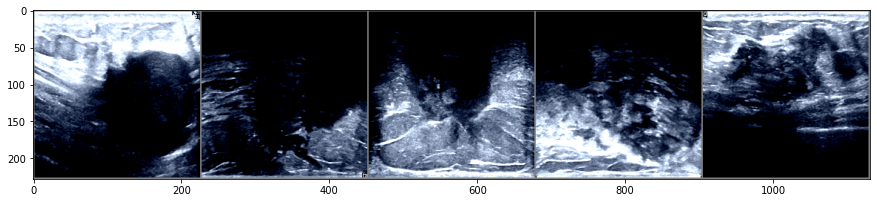

GroundTruth:  malignant malignant malignant malignant malignant
Shape of image is torch.Size([3, 224, 224])
Amount of Images in Train Dataset is 272
Amount of Images in Validation Dataset is 49


In [296]:
#Show train images and their label
num_images_to_show=5
train_dataloader_to_show = DataLoader(train_data, batch_size=num_images_to_show,shuffle=False)
dataiter = iter(train_dataloader_to_show)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:num_images_to_show]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images_to_show)))
print('Shape of image is {}'.format(images[0].shape)) 
print('Amount of Images in Train Dataset is {}'.format(train_dataloader.sampler.num_samples))
print('Amount of Images in Validation Dataset is {}'.format(validation_dataloader.sampler.num_samples))

In [300]:
#Load ResNet18
model = torchvision.models.resnet18(pretrained=True)

In [301]:
#Define optimizer, loss function and max epochs
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
max_epochs = 500

In [307]:
from tqdm import tqdm 

# initialize list of losses vs. epochs
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

def train(model, train_loader, validloader, optimizer, criterion, max_epochs=50):
    epoch_num=1
    for epoch in tqdm(range(max_epochs)):
        #  initialize average loss value
        train_loss_mean = 0
        valid_loss_mean = 0
        # Train 1 Epoch: loop over batches
        for batch_idx, batch in enumerate(train_loader):
            # Train 1 batch
            # organize batch to samples and tragets
            samples, targets = batch
            # zero the optimizer gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(samples)
            # Calculate loss
            loss=criterion(outputs, targets)
            # Back-propagation
            loss.backward()
            # optimizer step
            optimizer.step()
            # aggregate loss
            train_loss_mean += loss.item()
        #train_loss_mean /= (batch_idx + 1)
        
        
        model.eval()     # Optional when not using Model Specific layer
        for data, labels in validloader:
            # Forward Pass
            target = model(data)
            # Find the Loss
            loss = criterion(target,labels)
            # Calculate Loss
            valid_loss_mean += loss.item()
        
        # Normalize loss
        train_loss_mean /= len(train_loader)
        valid_loss_mean /= len(validloader)
        
        print(f'Epoch {epoch_num} \t\t Training Loss: {(train_loss_mean)} \t\t Validation Loss: {(valid_loss_mean)}')
        #print('Loss: {}, Epoch: {}'.format(loss_mean, epoch_num))
        epoch_num+=1
        # Add loss to list
        train_loss_list.append(train_loss_mean)
        val_loss_list.append(valid_loss_mean)
    return train_loss_list,val_loss_list
train_loss_list, val_loss_list = train(model,train_dataloader,validation_dataloader,optimizer,criterion,max_epochs)

  0%|                                         | 1/500 [00:17<2:28:52, 17.90s/it]

Epoch 1 		 Training Loss: 3.105455700840269 		 Validation Loss: 79.11671295166016


  0%|▏                                        | 2/500 [00:37<2:35:32, 18.74s/it]

Epoch 2 		 Training Loss: 10.670563670141357 		 Validation Loss: 1.1083356618881226


  1%|▏                                        | 3/500 [00:54<2:29:46, 18.08s/it]

Epoch 3 		 Training Loss: 1.2764584911721093 		 Validation Loss: 1.4126907587051392


  1%|▎                                        | 4/500 [01:11<2:26:53, 17.77s/it]

Epoch 4 		 Training Loss: 1.1915877205984933 		 Validation Loss: 1.0799069285392762


  1%|▍                                        | 5/500 [01:29<2:25:30, 17.64s/it]

Epoch 5 		 Training Loss: 1.1626502669283323 		 Validation Loss: 1.7194462776184083


  1%|▍                                        | 6/500 [01:48<2:29:03, 18.10s/it]

Epoch 6 		 Training Loss: 1.2440187356301717 		 Validation Loss: 1.0940871953964233


  1%|▌                                        | 7/500 [02:16<2:56:26, 21.47s/it]

Epoch 7 		 Training Loss: 1.14856852378164 		 Validation Loss: 1.0779207706451417


  2%|▋                                        | 8/500 [02:35<2:49:44, 20.70s/it]

Epoch 8 		 Training Loss: 1.1527631602116994 		 Validation Loss: 1.1746554613113402


  2%|▋                                        | 9/500 [02:54<2:44:28, 20.10s/it]

Epoch 9 		 Training Loss: 1.1730385507856096 		 Validation Loss: 1.1186463594436646


  2%|▊                                       | 10/500 [03:12<2:38:33, 19.41s/it]

Epoch 10 		 Training Loss: 1.163415857723781 		 Validation Loss: 1.3183899164199828


  2%|▉                                       | 11/500 [03:29<2:32:58, 18.77s/it]

Epoch 11 		 Training Loss: 1.167907259293965 		 Validation Loss: 1.160506296157837


  2%|▉                                       | 12/500 [03:47<2:29:19, 18.36s/it]

Epoch 12 		 Training Loss: 1.140632574047361 		 Validation Loss: 1.1947983264923097


  3%|█                                       | 13/500 [04:04<2:26:38, 18.07s/it]

Epoch 13 		 Training Loss: 1.1447485791785377 		 Validation Loss: 1.2561786651611329


  3%|█                                       | 14/500 [04:23<2:28:13, 18.30s/it]

Epoch 14 		 Training Loss: 1.1200025635106223 		 Validation Loss: 1.2752153635025025


  3%|█▏                                      | 15/500 [04:40<2:25:56, 18.05s/it]

Epoch 15 		 Training Loss: 1.1303447357245855 		 Validation Loss: 1.188960075378418


  3%|█▎                                      | 16/500 [04:58<2:24:37, 17.93s/it]

Epoch 16 		 Training Loss: 1.156327179500035 		 Validation Loss: 1.149455189704895


  3%|█▎                                      | 17/500 [05:15<2:23:03, 17.77s/it]

Epoch 17 		 Training Loss: 1.1186201061521257 		 Validation Loss: 1.126424789428711


  4%|█▍                                      | 18/500 [05:34<2:25:37, 18.13s/it]

Epoch 18 		 Training Loss: 1.1058164473090852 		 Validation Loss: 1.1727936267852783


  4%|█▌                                      | 19/500 [05:55<2:32:27, 19.02s/it]

Epoch 19 		 Training Loss: 1.128932876246316 		 Validation Loss: 1.120346736907959


  4%|█▌                                      | 20/500 [06:14<2:31:14, 18.90s/it]

Epoch 20 		 Training Loss: 1.1132822675364358 		 Validation Loss: 1.147556209564209


  4%|█▋                                      | 21/500 [06:33<2:29:55, 18.78s/it]

Epoch 21 		 Training Loss: 1.1416499657290322 		 Validation Loss: 1.1573921203613282


  4%|█▊                                      | 22/500 [06:51<2:29:21, 18.75s/it]

Epoch 22 		 Training Loss: 1.1486037799290247 		 Validation Loss: 1.2183356285095215


  5%|█▊                                      | 23/500 [07:10<2:28:56, 18.74s/it]

Epoch 23 		 Training Loss: 1.131619815315519 		 Validation Loss: 1.1389500379562378


  5%|█▉                                      | 24/500 [07:27<2:24:37, 18.23s/it]

Epoch 24 		 Training Loss: 1.1332560735089439 		 Validation Loss: 1.2601502418518067


  5%|██                                      | 25/500 [07:44<2:22:16, 17.97s/it]

Epoch 25 		 Training Loss: 1.1306131311825343 		 Validation Loss: 1.1442452669143677


  5%|██                                      | 26/500 [08:02<2:20:12, 17.75s/it]

Epoch 26 		 Training Loss: 1.1341268292495184 		 Validation Loss: 1.1168559432029723


  5%|██▏                                     | 27/500 [08:19<2:19:09, 17.65s/it]

Epoch 27 		 Training Loss: 1.1030484735965729 		 Validation Loss: 1.0976089239120483


  6%|██▏                                     | 28/500 [08:37<2:19:27, 17.73s/it]

Epoch 28 		 Training Loss: 1.1202318455491747 		 Validation Loss: 1.0775068759918214


  6%|██▎                                     | 29/500 [08:55<2:20:21, 17.88s/it]

Epoch 29 		 Training Loss: 1.1163669994899206 		 Validation Loss: 1.1070173501968383


  6%|██▍                                     | 30/500 [09:15<2:25:00, 18.51s/it]

Epoch 30 		 Training Loss: 1.115128395812852 		 Validation Loss: 1.0781840562820435


  6%|██▍                                     | 31/500 [09:38<2:34:53, 19.81s/it]

Epoch 31 		 Training Loss: 1.1056930082184928 		 Validation Loss: 1.1211065769195556


  6%|██▌                                     | 32/500 [09:59<2:36:41, 20.09s/it]

Epoch 32 		 Training Loss: 1.116914872612272 		 Validation Loss: 1.1696790218353272


  7%|██▋                                     | 33/500 [10:20<2:38:46, 20.40s/it]

Epoch 33 		 Training Loss: 1.1267755031585693 		 Validation Loss: 1.1433955192565919


  7%|██▋                                     | 34/500 [10:40<2:38:22, 20.39s/it]

Epoch 34 		 Training Loss: 1.1209260608468736 		 Validation Loss: 1.1287750720977783


  7%|██▊                                     | 35/500 [10:58<2:32:33, 19.69s/it]

Epoch 35 		 Training Loss: 1.1101211266858237 		 Validation Loss: 1.0953497171401978


  7%|██▉                                     | 36/500 [11:16<2:28:53, 19.25s/it]

Epoch 36 		 Training Loss: 1.1120763761656625 		 Validation Loss: 1.179149079322815


  7%|██▉                                     | 37/500 [11:35<2:25:54, 18.91s/it]

Epoch 37 		 Training Loss: 1.1089565370764052 		 Validation Loss: 1.1083287715911865


  8%|███                                     | 38/500 [11:53<2:23:33, 18.64s/it]

Epoch 38 		 Training Loss: 1.1198057660034724 		 Validation Loss: 1.1277159690856933


  8%|███                                     | 39/500 [12:14<2:29:53, 19.51s/it]

Epoch 39 		 Training Loss: 1.1127302667924337 		 Validation Loss: 1.1165602922439575


  8%|███▏                                    | 40/500 [12:33<2:29:10, 19.46s/it]

Epoch 40 		 Training Loss: 1.1066304871014185 		 Validation Loss: 1.1396252393722535


  8%|███▎                                    | 41/500 [12:51<2:25:09, 18.97s/it]

Epoch 41 		 Training Loss: 1.1115195155143738 		 Validation Loss: 1.0894806861877442


  8%|███▎                                    | 42/500 [13:09<2:21:18, 18.51s/it]

Epoch 42 		 Training Loss: 1.1117865528379167 		 Validation Loss: 1.1017892360687256


  9%|███▍                                    | 43/500 [13:27<2:20:43, 18.48s/it]

Epoch 43 		 Training Loss: 1.1138677043574197 		 Validation Loss: 1.1552696704864502


  9%|███▌                                    | 44/500 [13:47<2:24:16, 18.98s/it]

Epoch 44 		 Training Loss: 1.1139595764023917 		 Validation Loss: 1.1204987287521362


  9%|███▌                                    | 45/500 [14:06<2:24:08, 19.01s/it]

Epoch 45 		 Training Loss: 1.1080795313630785 		 Validation Loss: 1.0938714265823364


  9%|███▋                                    | 46/500 [14:25<2:23:44, 19.00s/it]

Epoch 46 		 Training Loss: 1.100201427936554 		 Validation Loss: 1.1241604328155517


  9%|███▊                                    | 47/500 [14:45<2:24:26, 19.13s/it]

Epoch 47 		 Training Loss: 1.1033361767019545 		 Validation Loss: 1.1226174592971803


 10%|███▊                                    | 48/500 [15:04<2:23:54, 19.10s/it]

Epoch 48 		 Training Loss: 1.104532954948289 		 Validation Loss: 1.0916619777679444


 10%|███▉                                    | 49/500 [15:23<2:23:16, 19.06s/it]

Epoch 49 		 Training Loss: 1.1149238688605172 		 Validation Loss: 1.140674614906311


 10%|████                                    | 50/500 [15:42<2:23:08, 19.09s/it]

Epoch 50 		 Training Loss: 1.1262598037719727 		 Validation Loss: 1.1393875122070312


 10%|████                                    | 51/500 [16:01<2:22:50, 19.09s/it]

Epoch 51 		 Training Loss: 1.1149879395961761 		 Validation Loss: 1.1399332523345946


 10%|████▏                                   | 52/500 [16:20<2:22:20, 19.06s/it]

Epoch 52 		 Training Loss: 1.1144567004271917 		 Validation Loss: 1.1091625928878783


 11%|████▏                                   | 53/500 [16:39<2:22:05, 19.07s/it]

Epoch 53 		 Training Loss: 1.1153541037014552 		 Validation Loss: 1.094492530822754


 11%|████▎                                   | 54/500 [16:59<2:23:12, 19.27s/it]

Epoch 54 		 Training Loss: 1.1052383056708746 		 Validation Loss: 1.0911594867706298


 11%|████▍                                   | 55/500 [17:21<2:29:10, 20.11s/it]

Epoch 55 		 Training Loss: 1.1271152368613653 		 Validation Loss: 1.0940824270248413


 11%|████▍                                   | 56/500 [17:45<2:36:41, 21.17s/it]

Epoch 56 		 Training Loss: 1.1243166838373457 		 Validation Loss: 1.1354348421096803


 11%|████▌                                   | 57/500 [18:06<2:37:00, 21.27s/it]

Epoch 57 		 Training Loss: 1.1139036118984222 		 Validation Loss: 1.0968509197235108


 12%|████▋                                   | 58/500 [18:27<2:35:14, 21.07s/it]

Epoch 58 		 Training Loss: 1.101437074797494 		 Validation Loss: 1.1131712198257446


 12%|████▋                                   | 59/500 [18:47<2:33:59, 20.95s/it]

Epoch 59 		 Training Loss: 1.1084790996142797 		 Validation Loss: 1.1185251712799071


 12%|████▊                                   | 60/500 [19:08<2:33:36, 20.95s/it]

Epoch 60 		 Training Loss: 1.1014309482915061 		 Validation Loss: 1.0987677812576293


 12%|████▉                                   | 61/500 [19:28<2:30:55, 20.63s/it]

Epoch 61 		 Training Loss: 1.1031078823975153 		 Validation Loss: 1.087338137626648


 12%|████▉                                   | 62/500 [19:48<2:29:02, 20.42s/it]

Epoch 62 		 Training Loss: 1.1133068587098802 		 Validation Loss: 1.1263817071914672


 13%|█████                                   | 63/500 [20:07<2:25:28, 19.97s/it]

Epoch 63 		 Training Loss: 1.114667786019189 		 Validation Loss: 1.119394874572754


 13%|█████                                   | 64/500 [20:29<2:30:27, 20.71s/it]

Epoch 64 		 Training Loss: 1.1073457854134696 		 Validation Loss: 1.125354814529419


 13%|█████▏                                  | 65/500 [20:52<2:34:41, 21.34s/it]

Epoch 65 		 Training Loss: 1.1089149245194025 		 Validation Loss: 1.1041762113571167


 13%|█████▎                                  | 66/500 [21:12<2:31:53, 21.00s/it]

Epoch 66 		 Training Loss: 1.11752045580319 		 Validation Loss: 1.1247399568557739


 13%|█████▎                                  | 67/500 [21:32<2:29:06, 20.66s/it]

Epoch 67 		 Training Loss: 1.1064821226256234 		 Validation Loss: 1.1089946746826171


 14%|█████▍                                  | 68/500 [21:52<2:27:38, 20.51s/it]

Epoch 68 		 Training Loss: 1.107339927128383 		 Validation Loss: 1.1251868963241578


 14%|█████▌                                  | 69/500 [22:13<2:26:45, 20.43s/it]

Epoch 69 		 Training Loss: 1.1036135128566198 		 Validation Loss: 1.1030227661132812


 14%|█████▌                                  | 70/500 [22:32<2:24:50, 20.21s/it]

Epoch 70 		 Training Loss: 1.1026818794863564 		 Validation Loss: 1.1226041555404662


 14%|█████▋                                  | 71/500 [22:53<2:25:57, 20.41s/it]

Epoch 71 		 Training Loss: 1.1075983090060098 		 Validation Loss: 1.126693034172058


 14%|█████▊                                  | 72/500 [23:15<2:28:28, 20.81s/it]

Epoch 72 		 Training Loss: 1.099476933479309 		 Validation Loss: 1.105352234840393


 15%|█████▊                                  | 73/500 [23:33<2:22:27, 20.02s/it]

Epoch 73 		 Training Loss: 1.1024664342403412 		 Validation Loss: 1.0880924224853517


 15%|█████▉                                  | 74/500 [23:51<2:18:26, 19.50s/it]

Epoch 74 		 Training Loss: 1.1080430107457298 		 Validation Loss: 1.110069489479065


 15%|██████                                  | 75/500 [24:10<2:15:44, 19.16s/it]

Epoch 75 		 Training Loss: 1.1073692866734095 		 Validation Loss: 1.1141019344329834


 15%|██████                                  | 76/500 [24:28<2:13:15, 18.86s/it]

Epoch 76 		 Training Loss: 1.102391357932772 		 Validation Loss: 1.0943026065826416


 15%|██████▏                                 | 77/500 [24:46<2:10:39, 18.53s/it]

Epoch 77 		 Training Loss: 1.108440101146698 		 Validation Loss: 1.1182642221450805


 16%|██████▏                                 | 78/500 [25:03<2:08:33, 18.28s/it]

Epoch 78 		 Training Loss: 1.100381578717913 		 Validation Loss: 1.0997291803359985


 16%|██████▎                                 | 79/500 [25:21<2:06:59, 18.10s/it]

Epoch 79 		 Training Loss: 1.1041482133524758 		 Validation Loss: 1.1052269220352173


 16%|██████▍                                 | 80/500 [25:40<2:07:38, 18.23s/it]

Epoch 80 		 Training Loss: 1.1076323347432273 		 Validation Loss: 1.0933258771896361


 16%|██████▍                                 | 81/500 [25:58<2:06:57, 18.18s/it]

Epoch 81 		 Training Loss: 1.1049495424543108 		 Validation Loss: 1.101665163040161


 16%|██████▌                                 | 82/500 [26:17<2:07:51, 18.35s/it]

Epoch 82 		 Training Loss: 1.1026555384908403 		 Validation Loss: 1.1088796615600587


 17%|██████▋                                 | 83/500 [26:35<2:06:56, 18.27s/it]

Epoch 83 		 Training Loss: 1.1047256972108568 		 Validation Loss: 1.112800621986389


 17%|██████▋                                 | 84/500 [26:52<2:05:11, 18.06s/it]

Epoch 84 		 Training Loss: 1.0998466334172659 		 Validation Loss: 1.1258580923080443


 17%|██████▊                                 | 85/500 [27:10<2:04:20, 17.98s/it]

Epoch 85 		 Training Loss: 1.1014839112758636 		 Validation Loss: 1.1046724796295166


 17%|██████▉                                 | 86/500 [27:28<2:03:35, 17.91s/it]

Epoch 86 		 Training Loss: 1.1064263454505376 		 Validation Loss: 1.1087470293045043


 17%|██████▉                                 | 87/500 [27:45<2:02:51, 17.85s/it]

Epoch 87 		 Training Loss: 1.1040394178458623 		 Validation Loss: 1.1061071395874023


 18%|███████                                 | 88/500 [28:03<2:01:57, 17.76s/it]

Epoch 88 		 Training Loss: 1.1014641310487474 		 Validation Loss: 1.1140218496322631


 18%|███████                                 | 89/500 [28:21<2:01:58, 17.81s/it]

Epoch 89 		 Training Loss: 1.101029864379338 		 Validation Loss: 1.1152473449707032


 18%|███████▏                                | 90/500 [28:39<2:01:44, 17.81s/it]

Epoch 90 		 Training Loss: 1.103195458650589 		 Validation Loss: 1.10583393573761


 18%|███████▎                                | 91/500 [28:57<2:01:50, 17.87s/it]

Epoch 91 		 Training Loss: 1.101093637091773 		 Validation Loss: 1.103069829940796


 18%|███████▎                                | 92/500 [29:14<2:00:23, 17.70s/it]

Epoch 92 		 Training Loss: 1.10347238608769 		 Validation Loss: 1.103670358657837


 19%|███████▍                                | 93/500 [29:32<2:00:35, 17.78s/it]

Epoch 93 		 Training Loss: 1.0992004573345184 		 Validation Loss: 1.117908787727356


 19%|███████▌                                | 94/500 [29:50<1:59:52, 17.71s/it]

Epoch 94 		 Training Loss: 1.1004840092999595 		 Validation Loss: 1.1041496038436889


 19%|███████▌                                | 95/500 [30:07<1:59:19, 17.68s/it]

Epoch 95 		 Training Loss: 1.109877416065761 		 Validation Loss: 1.1052563667297364


 19%|███████▋                                | 96/500 [30:25<1:58:40, 17.62s/it]

Epoch 96 		 Training Loss: 1.105334541627339 		 Validation Loss: 1.1033647060394287


 19%|███████▊                                | 97/500 [30:43<1:59:28, 17.79s/it]

Epoch 97 		 Training Loss: 1.1066100682531084 		 Validation Loss: 1.1345728158950805


 20%|███████▊                                | 98/500 [31:01<1:59:19, 17.81s/it]

Epoch 98 		 Training Loss: 1.1072323407445634 		 Validation Loss: 1.0981297969818116


 20%|███████▉                                | 99/500 [31:18<1:58:49, 17.78s/it]

Epoch 99 		 Training Loss: 1.1058537023408073 		 Validation Loss: 1.108725905418396


 20%|███████▊                               | 100/500 [31:37<1:59:44, 17.96s/it]

Epoch 100 		 Training Loss: 1.10639865057809 		 Validation Loss: 1.0989753246307372


 20%|███████▉                               | 101/500 [31:55<1:59:00, 17.90s/it]

Epoch 101 		 Training Loss: 1.099489484514509 		 Validation Loss: 1.1143298625946045


 20%|███████▉                               | 102/500 [32:12<1:58:14, 17.83s/it]

Epoch 102 		 Training Loss: 1.1044798578534807 		 Validation Loss: 1.1087711811065675


 21%|████████                               | 103/500 [32:30<1:58:03, 17.84s/it]

Epoch 103 		 Training Loss: 1.1071469911507197 		 Validation Loss: 1.104590654373169


 21%|████████                               | 104/500 [32:48<1:58:34, 17.97s/it]

Epoch 104 		 Training Loss: 1.1052174781050002 		 Validation Loss: 1.1224209308624267


 21%|████████▏                              | 105/500 [33:06<1:58:02, 17.93s/it]

Epoch 105 		 Training Loss: 1.1035079998629433 		 Validation Loss: 1.1204737901687623


 21%|████████▎                              | 106/500 [33:24<1:57:25, 17.88s/it]

Epoch 106 		 Training Loss: 1.1013206498963493 		 Validation Loss: 1.1146483182907105


 21%|████████▎                              | 107/500 [33:42<1:56:33, 17.80s/it]

Epoch 107 		 Training Loss: 1.1047283623899733 		 Validation Loss: 1.1163552761077882


 22%|████████▍                              | 108/500 [33:59<1:56:18, 17.80s/it]

Epoch 108 		 Training Loss: 1.1015930558953966 		 Validation Loss: 1.0993097305297852


 22%|████████▌                              | 109/500 [34:18<1:56:45, 17.92s/it]

Epoch 109 		 Training Loss: 1.1023057230881281 		 Validation Loss: 1.1055243968963624


 22%|████████▌                              | 110/500 [34:36<1:56:42, 17.95s/it]

Epoch 110 		 Training Loss: 1.100856410605567 		 Validation Loss: 1.1101323127746583


 22%|████████▋                              | 111/500 [34:53<1:56:16, 17.93s/it]

Epoch 111 		 Training Loss: 1.1023832602160317 		 Validation Loss: 1.105532670021057


 22%|████████▋                              | 112/500 [35:11<1:55:19, 17.83s/it]

Epoch 112 		 Training Loss: 1.0994699043887002 		 Validation Loss: 1.1095375537872314


 23%|████████▊                              | 113/500 [35:29<1:55:19, 17.88s/it]

Epoch 113 		 Training Loss: 1.108510890177318 		 Validation Loss: 1.1093009471893311


 23%|████████▉                              | 114/500 [35:47<1:55:28, 17.95s/it]

Epoch 114 		 Training Loss: 1.1037202349730901 		 Validation Loss: 1.1126543283462524


 23%|████████▉                              | 115/500 [36:05<1:54:55, 17.91s/it]

Epoch 115 		 Training Loss: 1.1007119842938013 		 Validation Loss: 1.1052427530288695


 23%|█████████                              | 116/500 [36:23<1:54:33, 17.90s/it]

Epoch 116 		 Training Loss: 1.1025554920945848 		 Validation Loss: 1.106262993812561


 23%|█████████▏                             | 117/500 [36:41<1:54:01, 17.86s/it]

Epoch 117 		 Training Loss: 1.0977209976741247 		 Validation Loss: 1.12285418510437


 24%|█████████▏                             | 118/500 [36:58<1:53:22, 17.81s/it]

Epoch 118 		 Training Loss: 1.1008016339370184 		 Validation Loss: 1.1124409675598144


 24%|█████████▎                             | 119/500 [37:17<1:55:02, 18.12s/it]

Epoch 119 		 Training Loss: 1.1020070825304304 		 Validation Loss: 1.1154151439666748


 24%|█████████▎                             | 120/500 [37:35<1:55:03, 18.17s/it]

Epoch 120 		 Training Loss: 1.103224081652505 		 Validation Loss: 1.1228826284408568


 24%|█████████▍                             | 121/500 [37:53<1:53:54, 18.03s/it]

Epoch 121 		 Training Loss: 1.1026344299316406 		 Validation Loss: 1.1063358783721924


 24%|█████████▌                             | 122/500 [38:11<1:53:24, 18.00s/it]

Epoch 122 		 Training Loss: 1.1022374502250127 		 Validation Loss: 1.1146072149276733


 25%|█████████▌                             | 123/500 [38:29<1:52:30, 17.91s/it]

Epoch 123 		 Training Loss: 1.1035167830330985 		 Validation Loss: 1.118534016609192


 25%|█████████▋                             | 124/500 [38:48<1:53:54, 18.18s/it]

Epoch 124 		 Training Loss: 1.1016945838928223 		 Validation Loss: 1.1024304628372192


 25%|█████████▊                             | 125/500 [39:06<1:53:18, 18.13s/it]

Epoch 125 		 Training Loss: 1.1014366064752852 		 Validation Loss: 1.1024285316467286


 25%|█████████▊                             | 126/500 [39:23<1:52:32, 18.06s/it]

Epoch 126 		 Training Loss: 1.1018221931798118 		 Validation Loss: 1.1017385244369506


 25%|█████████▉                             | 127/500 [39:41<1:51:41, 17.97s/it]

Epoch 127 		 Training Loss: 1.1006900582994734 		 Validation Loss: 1.1076670646667481


 26%|█████████▉                             | 128/500 [39:59<1:51:22, 17.96s/it]

Epoch 128 		 Training Loss: 1.1022047996520996 		 Validation Loss: 1.1161286115646363


 26%|██████████                             | 129/500 [40:17<1:50:05, 17.80s/it]

Epoch 129 		 Training Loss: 1.1008694512503487 		 Validation Loss: 1.1099757909774781


 26%|██████████▏                            | 130/500 [40:35<1:50:18, 17.89s/it]

Epoch 130 		 Training Loss: 1.103877386876515 		 Validation Loss: 1.107648777961731


 26%|██████████▏                            | 131/500 [40:53<1:50:29, 17.97s/it]

Epoch 131 		 Training Loss: 1.0997399730341775 		 Validation Loss: 1.1192171096801757


 26%|██████████▎                            | 132/500 [41:11<1:49:49, 17.91s/it]

Epoch 132 		 Training Loss: 1.1008691106523787 		 Validation Loss: 1.1060431480407715


 27%|██████████▎                            | 133/500 [41:28<1:48:44, 17.78s/it]

Epoch 133 		 Training Loss: 1.1014038366930825 		 Validation Loss: 1.1045764446258546


 27%|██████████▍                            | 134/500 [41:46<1:48:05, 17.72s/it]

Epoch 134 		 Training Loss: 1.1034703723021917 		 Validation Loss: 1.1176595449447633


 27%|██████████▌                            | 135/500 [42:03<1:47:48, 17.72s/it]

Epoch 135 		 Training Loss: 1.1029883325099945 		 Validation Loss: 1.1013250827789307


 27%|██████████▌                            | 136/500 [42:21<1:47:42, 17.75s/it]

Epoch 136 		 Training Loss: 1.1074020053659166 		 Validation Loss: 1.1074772357940674


 27%|██████████▋                            | 137/500 [42:39<1:47:44, 17.81s/it]

Epoch 137 		 Training Loss: 1.1052033177443914 		 Validation Loss: 1.107801127433777


 28%|██████████▊                            | 138/500 [42:57<1:47:49, 17.87s/it]

Epoch 138 		 Training Loss: 1.1022342656339918 		 Validation Loss: 1.1040735483169555


 28%|██████████▊                            | 139/500 [43:15<1:47:18, 17.83s/it]

Epoch 139 		 Training Loss: 1.1026162121977126 		 Validation Loss: 1.107217025756836


 28%|██████████▉                            | 140/500 [43:33<1:48:01, 18.00s/it]

Epoch 140 		 Training Loss: 1.1002403029373713 		 Validation Loss: 1.1038084030151367


 28%|██████████▉                            | 141/500 [43:52<1:48:38, 18.16s/it]

Epoch 141 		 Training Loss: 1.1008774978773934 		 Validation Loss: 1.1132001161575318


 28%|███████████                            | 142/500 [44:10<1:48:50, 18.24s/it]

Epoch 142 		 Training Loss: 1.1027821472712926 		 Validation Loss: 1.1136785984039306


 29%|███████████▏                           | 143/500 [44:28<1:47:26, 18.06s/it]

Epoch 143 		 Training Loss: 1.0975908466747828 		 Validation Loss: 1.1022826433181763


 29%|███████████▏                           | 144/500 [44:46<1:47:14, 18.08s/it]

Epoch 144 		 Training Loss: 1.1034768181187766 		 Validation Loss: 1.112095880508423


 29%|███████████▎                           | 145/500 [45:04<1:46:46, 18.05s/it]

Epoch 145 		 Training Loss: 1.105621623141425 		 Validation Loss: 1.103360915184021


 29%|███████████▍                           | 146/500 [45:22<1:45:49, 17.94s/it]

Epoch 146 		 Training Loss: 1.1016263280596053 		 Validation Loss: 1.1171285152435302


 29%|███████████▍                           | 147/500 [45:41<1:47:15, 18.23s/it]

Epoch 147 		 Training Loss: 1.1031136427606856 		 Validation Loss: 1.1146848678588868


 30%|███████████▌                           | 148/500 [45:59<1:46:33, 18.16s/it]

Epoch 148 		 Training Loss: 1.1017117713178908 		 Validation Loss: 1.1068565607070924


 30%|███████████▌                           | 149/500 [46:16<1:45:41, 18.07s/it]

Epoch 149 		 Training Loss: 1.1047089185033525 		 Validation Loss: 1.1006515502929688


 30%|███████████▋                           | 150/500 [46:34<1:45:04, 18.01s/it]

Epoch 150 		 Training Loss: 1.1023381778172083 		 Validation Loss: 1.1196308851242065


 30%|███████████▊                           | 151/500 [46:52<1:44:47, 18.02s/it]

Epoch 151 		 Training Loss: 1.1019683139664787 		 Validation Loss: 1.100488257408142


 30%|███████████▊                           | 152/500 [47:10<1:44:31, 18.02s/it]

Epoch 152 		 Training Loss: 1.1038419646876199 		 Validation Loss: 1.105002999305725


 31%|███████████▉                           | 153/500 [47:28<1:44:18, 18.04s/it]

Epoch 153 		 Training Loss: 1.1008557379245758 		 Validation Loss: 1.1105206727981567


 31%|████████████                           | 154/500 [47:46<1:43:27, 17.94s/it]

Epoch 154 		 Training Loss: 1.1026563686983926 		 Validation Loss: 1.1053958892822267


 31%|████████████                           | 155/500 [48:04<1:42:42, 17.86s/it]

Epoch 155 		 Training Loss: 1.1030452932630266 		 Validation Loss: 1.106502938270569


 31%|████████████▏                          | 156/500 [48:21<1:41:52, 17.77s/it]

Epoch 156 		 Training Loss: 1.098896141563143 		 Validation Loss: 1.113158106803894


 31%|████████████▏                          | 157/500 [48:40<1:42:28, 17.93s/it]

Epoch 157 		 Training Loss: 1.1018504457814353 		 Validation Loss: 1.1039278507232666


 32%|████████████▎                          | 158/500 [48:58<1:42:01, 17.90s/it]

Epoch 158 		 Training Loss: 1.1004533980573927 		 Validation Loss: 1.0982175588607788


 32%|████████████▍                          | 159/500 [49:15<1:41:49, 17.92s/it]

Epoch 159 		 Training Loss: 1.1037734704358237 		 Validation Loss: 1.108990979194641


 32%|████████████▍                          | 160/500 [49:33<1:41:13, 17.86s/it]

Epoch 160 		 Training Loss: 1.1000428199768066 		 Validation Loss: 1.1028586149215698


 32%|████████████▌                          | 161/500 [49:51<1:41:00, 17.88s/it]

Epoch 161 		 Training Loss: 1.1066461248057229 		 Validation Loss: 1.1122331380844117


 32%|████████████▋                          | 162/500 [50:09<1:40:30, 17.84s/it]

Epoch 162 		 Training Loss: 1.1044055308614458 		 Validation Loss: 1.1058926820755004


 33%|████████████▋                          | 163/500 [50:27<1:40:02, 17.81s/it]

Epoch 163 		 Training Loss: 1.1016603665692466 		 Validation Loss: 1.1080719709396363


 33%|████████████▊                          | 164/500 [50:45<1:40:31, 17.95s/it]

Epoch 164 		 Training Loss: 1.1015226670673914 		 Validation Loss: 1.1045049667358398


 33%|████████████▊                          | 165/500 [51:04<1:41:26, 18.17s/it]

Epoch 165 		 Training Loss: 1.0993496179580688 		 Validation Loss: 1.1119595050811768


 33%|████████████▉                          | 166/500 [51:21<1:40:23, 18.03s/it]

Epoch 166 		 Training Loss: 1.1073396461350578 		 Validation Loss: 1.1248226642608643


 33%|█████████████                          | 167/500 [51:39<1:39:17, 17.89s/it]

Epoch 167 		 Training Loss: 1.101167802299772 		 Validation Loss: 1.1062711000442504


 34%|█████████████                          | 168/500 [51:56<1:38:19, 17.77s/it]

Epoch 168 		 Training Loss: 1.108948596886226 		 Validation Loss: 1.1094706296920775


 34%|█████████████▏                         | 169/500 [52:15<1:39:29, 18.03s/it]

Epoch 169 		 Training Loss: 1.1016737605844225 		 Validation Loss: 1.1097016334533691


 34%|█████████████▎                         | 170/500 [52:32<1:38:10, 17.85s/it]

Epoch 170 		 Training Loss: 1.1017091529709953 		 Validation Loss: 1.109522247314453


 34%|█████████████▎                         | 171/500 [52:51<1:38:37, 17.99s/it]

Epoch 171 		 Training Loss: 1.1007080333573478 		 Validation Loss: 1.1076403856277466


 34%|█████████████▍                         | 172/500 [53:08<1:37:22, 17.81s/it]

Epoch 172 		 Training Loss: 1.1018857445035661 		 Validation Loss: 1.0979553937911988


 35%|█████████████▍                         | 173/500 [53:26<1:36:56, 17.79s/it]

Epoch 173 		 Training Loss: 1.1002632933003562 		 Validation Loss: 1.1130796670913696


 35%|█████████████▌                         | 174/500 [53:43<1:36:16, 17.72s/it]

Epoch 174 		 Training Loss: 1.1029778718948364 		 Validation Loss: 1.115422296524048


 35%|█████████████▋                         | 175/500 [54:01<1:36:12, 17.76s/it]

Epoch 175 		 Training Loss: 1.1017546313149589 		 Validation Loss: 1.1159106969833374


 35%|█████████████▋                         | 176/500 [54:19<1:35:25, 17.67s/it]

Epoch 176 		 Training Loss: 1.1006234799112593 		 Validation Loss: 1.1090111255645752


 35%|█████████████▊                         | 177/500 [54:36<1:35:06, 17.67s/it]

Epoch 177 		 Training Loss: 1.1013911536761694 		 Validation Loss: 1.1010079860687256


 36%|█████████████▉                         | 178/500 [54:54<1:34:31, 17.61s/it]

Epoch 178 		 Training Loss: 1.1007968144757407 		 Validation Loss: 1.1085077047348022


 36%|█████████████▉                         | 179/500 [55:12<1:34:38, 17.69s/it]

Epoch 179 		 Training Loss: 1.1029776207038335 		 Validation Loss: 1.109746551513672


 36%|██████████████                         | 180/500 [55:29<1:34:09, 17.66s/it]

Epoch 180 		 Training Loss: 1.0982823967933655 		 Validation Loss: 1.1085958242416383


 36%|██████████████                         | 181/500 [55:47<1:33:40, 17.62s/it]

Epoch 181 		 Training Loss: 1.0996604561805725 		 Validation Loss: 1.1097848176956178


 36%|██████████████▏                        | 182/500 [56:05<1:34:19, 17.80s/it]

Epoch 182 		 Training Loss: 1.0984717777797155 		 Validation Loss: 1.1084760427474976


 37%|██████████████▎                        | 183/500 [56:23<1:34:15, 17.84s/it]

Epoch 183 		 Training Loss: 1.0986731605870383 		 Validation Loss: 1.1175991773605347


 37%|██████████████▎                        | 184/500 [56:41<1:33:28, 17.75s/it]

Epoch 184 		 Training Loss: 1.1014867978436607 		 Validation Loss: 1.1187677145004273


 37%|██████████████▍                        | 185/500 [56:58<1:33:05, 17.73s/it]

Epoch 185 		 Training Loss: 1.100145114319665 		 Validation Loss: 1.1099924564361572


 37%|██████████████▌                        | 186/500 [57:16<1:33:25, 17.85s/it]

Epoch 186 		 Training Loss: 1.0995548580374037 		 Validation Loss: 1.1034725189208985


 37%|██████████████▌                        | 187/500 [57:35<1:34:12, 18.06s/it]

Epoch 187 		 Training Loss: 1.1005604139396123 		 Validation Loss: 1.1054560899734498


 38%|██████████████▋                        | 188/500 [57:52<1:33:04, 17.90s/it]

Epoch 188 		 Training Loss: 1.1003930738994054 		 Validation Loss: 1.109366226196289


 38%|██████████████▋                        | 189/500 [58:10<1:32:33, 17.86s/it]

Epoch 189 		 Training Loss: 1.1013419500419073 		 Validation Loss: 1.113959503173828


 38%|██████████████▊                        | 190/500 [58:28<1:31:25, 17.69s/it]

Epoch 190 		 Training Loss: 1.1021766534873418 		 Validation Loss: 1.1012839317321776


 38%|██████████████▉                        | 191/500 [58:45<1:30:32, 17.58s/it]

Epoch 191 		 Training Loss: 1.1069792423929488 		 Validation Loss: 1.1238467693328857


 38%|██████████████▉                        | 192/500 [59:03<1:31:13, 17.77s/it]

Epoch 192 		 Training Loss: 1.1036336762564523 		 Validation Loss: 1.1008410215377809


 39%|███████████████                        | 193/500 [59:21<1:30:32, 17.70s/it]

Epoch 193 		 Training Loss: 1.1000256027494157 		 Validation Loss: 1.1206410884857179


 39%|███████████████▏                       | 194/500 [59:39<1:30:51, 17.81s/it]

Epoch 194 		 Training Loss: 1.1020372722830092 		 Validation Loss: 1.1142607927322388


 39%|███████████████▏                       | 195/500 [59:56<1:30:10, 17.74s/it]

Epoch 195 		 Training Loss: 1.1016196267945426 		 Validation Loss: 1.098037600517273


 39%|██████████████▌                      | 196/500 [1:00:14<1:30:17, 17.82s/it]

Epoch 196 		 Training Loss: 1.1012426955359322 		 Validation Loss: 1.1134243488311768


 39%|██████████████▌                      | 197/500 [1:00:32<1:29:54, 17.80s/it]

Epoch 197 		 Training Loss: 1.0990862080029078 		 Validation Loss: 1.1110060453414916


 40%|██████████████▋                      | 198/500 [1:00:50<1:29:57, 17.87s/it]

Epoch 198 		 Training Loss: 1.1013960540294647 		 Validation Loss: 1.1129698991775512


 40%|██████████████▋                      | 199/500 [1:01:08<1:30:23, 18.02s/it]

Epoch 199 		 Training Loss: 1.097809110369001 		 Validation Loss: 1.1066786050796509


 40%|██████████████▊                      | 200/500 [1:01:26<1:29:31, 17.91s/it]

Epoch 200 		 Training Loss: 1.1015512602669852 		 Validation Loss: 1.1158249855041504


 40%|██████████████▊                      | 201/500 [1:01:43<1:28:32, 17.77s/it]

Epoch 201 		 Training Loss: 1.1010100415774755 		 Validation Loss: 1.1023121356964112


 40%|██████████████▉                      | 202/500 [1:02:01<1:28:04, 17.73s/it]

Epoch 202 		 Training Loss: 1.1006756850651331 		 Validation Loss: 1.1052011251449585


 41%|███████████████                      | 203/500 [1:02:19<1:27:40, 17.71s/it]

Epoch 203 		 Training Loss: 1.0982417804854256 		 Validation Loss: 1.109711718559265


 41%|███████████████                      | 204/500 [1:02:36<1:27:05, 17.65s/it]

Epoch 204 		 Training Loss: 1.1010135114192963 		 Validation Loss: 1.1174933671951295


 41%|███████████████▏                     | 205/500 [1:02:54<1:26:38, 17.62s/it]

Epoch 205 		 Training Loss: 1.1020105736596244 		 Validation Loss: 1.1172701358795165


 41%|███████████████▏                     | 206/500 [1:03:11<1:26:20, 17.62s/it]

Epoch 206 		 Training Loss: 1.1014269079480852 		 Validation Loss: 1.1032960414886475


 41%|███████████████▎                     | 207/500 [1:03:30<1:27:46, 17.97s/it]

Epoch 207 		 Training Loss: 1.103586230959211 		 Validation Loss: 1.1077674150466919


 42%|███████████████▍                     | 208/500 [1:03:48<1:26:51, 17.85s/it]

Epoch 208 		 Training Loss: 1.1000445314816065 		 Validation Loss: 1.1094441890716553


 42%|███████████████▍                     | 209/500 [1:04:05<1:26:02, 17.74s/it]

Epoch 209 		 Training Loss: 1.0985832554953439 		 Validation Loss: 1.1143023252487183


 42%|███████████████▌                     | 210/500 [1:04:23<1:25:15, 17.64s/it]

Epoch 210 		 Training Loss: 1.098608319248472 		 Validation Loss: 1.1121670722961425


 42%|███████████████▌                     | 211/500 [1:04:41<1:25:10, 17.68s/it]

Epoch 211 		 Training Loss: 1.097597952399935 		 Validation Loss: 1.1100507020950316


 42%|███████████████▋                     | 212/500 [1:04:58<1:24:37, 17.63s/it]

Epoch 212 		 Training Loss: 1.0982979791504996 		 Validation Loss: 1.1129584550857543


 43%|███████████████▊                     | 213/500 [1:05:15<1:24:02, 17.57s/it]

Epoch 213 		 Training Loss: 1.1001706847122736 		 Validation Loss: 1.1162184715270995


 43%|███████████████▊                     | 214/500 [1:05:33<1:23:45, 17.57s/it]

Epoch 214 		 Training Loss: 1.100589828831809 		 Validation Loss: 1.1191388607025146


 43%|███████████████▉                     | 215/500 [1:05:51<1:23:37, 17.60s/it]

Epoch 215 		 Training Loss: 1.101704056773867 		 Validation Loss: 1.1108727931976319


 43%|███████████████▉                     | 216/500 [1:06:08<1:23:15, 17.59s/it]

Epoch 216 		 Training Loss: 1.1001074314117432 		 Validation Loss: 1.106343650817871


 43%|████████████████                     | 217/500 [1:06:26<1:23:25, 17.69s/it]

Epoch 217 		 Training Loss: 1.0999395251274109 		 Validation Loss: 1.1095301866531373


 44%|████████████████▏                    | 218/500 [1:06:44<1:22:51, 17.63s/it]

Epoch 218 		 Training Loss: 1.1049499298845018 		 Validation Loss: 1.1127737283706665


 44%|████████████████▏                    | 219/500 [1:07:01<1:22:40, 17.65s/it]

Epoch 219 		 Training Loss: 1.0986469345433372 		 Validation Loss: 1.1052263021469115


 44%|████████████████▎                    | 220/500 [1:07:19<1:22:07, 17.60s/it]

Epoch 220 		 Training Loss: 1.1014565101691656 		 Validation Loss: 1.113537645339966


 44%|████████████████▎                    | 221/500 [1:07:36<1:21:29, 17.52s/it]

Epoch 221 		 Training Loss: 1.1003253034182958 		 Validation Loss: 1.1005717515945435


 44%|████████████████▍                    | 222/500 [1:07:54<1:21:08, 17.51s/it]

Epoch 222 		 Training Loss: 1.0998436084815435 		 Validation Loss: 1.1097719192504882


 45%|████████████████▌                    | 223/500 [1:08:11<1:20:31, 17.44s/it]

Epoch 223 		 Training Loss: 1.0979104552950179 		 Validation Loss: 1.1135393857955933


 45%|████████████████▌                    | 224/500 [1:08:28<1:20:09, 17.42s/it]

Epoch 224 		 Training Loss: 1.1035520902701788 		 Validation Loss: 1.1187382698059083


 45%|████████████████▋                    | 225/500 [1:08:46<1:20:31, 17.57s/it]

Epoch 225 		 Training Loss: 1.098427870443889 		 Validation Loss: 1.1050894498825072


 45%|████████████████▋                    | 226/500 [1:09:04<1:20:03, 17.53s/it]

Epoch 226 		 Training Loss: 1.1035181624548775 		 Validation Loss: 1.1072941064834594


 45%|████████████████▊                    | 227/500 [1:09:21<1:20:04, 17.60s/it]

Epoch 227 		 Training Loss: 1.1010403888566154 		 Validation Loss: 1.113199496269226


 46%|████████████████▊                    | 228/500 [1:09:39<1:19:32, 17.55s/it]

Epoch 228 		 Training Loss: 1.0978684042181288 		 Validation Loss: 1.113099718093872


 46%|████████████████▉                    | 229/500 [1:09:57<1:19:45, 17.66s/it]

Epoch 229 		 Training Loss: 1.1023290710789817 		 Validation Loss: 1.110023522377014


 46%|█████████████████                    | 230/500 [1:10:15<1:19:45, 17.72s/it]

Epoch 230 		 Training Loss: 1.098196314913886 		 Validation Loss: 1.1129745960235595


 46%|█████████████████                    | 231/500 [1:10:33<1:20:17, 17.91s/it]

Epoch 231 		 Training Loss: 1.0992116502353124 		 Validation Loss: 1.1087050437927246


 46%|█████████████████▏                   | 232/500 [1:10:51<1:20:07, 17.94s/it]

Epoch 232 		 Training Loss: 1.0990349309785026 		 Validation Loss: 1.1105531692504882


 47%|█████████████████▏                   | 233/500 [1:11:09<1:20:13, 18.03s/it]

Epoch 233 		 Training Loss: 1.100547079529081 		 Validation Loss: 1.1097327947616578


 47%|█████████████████▎                   | 234/500 [1:11:27<1:19:52, 18.02s/it]

Epoch 234 		 Training Loss: 1.0979066746575492 		 Validation Loss: 1.109715986251831


 47%|█████████████████▍                   | 235/500 [1:11:46<1:19:56, 18.10s/it]

Epoch 235 		 Training Loss: 1.1044712577547346 		 Validation Loss: 1.1223437547683717


 47%|█████████████████▍                   | 236/500 [1:12:03<1:18:57, 17.95s/it]

Epoch 236 		 Training Loss: 1.0990414363997323 		 Validation Loss: 1.102825927734375


 47%|█████████████████▌                   | 237/500 [1:12:21<1:18:12, 17.84s/it]

Epoch 237 		 Training Loss: 1.1034566760063171 		 Validation Loss: 1.1034560203552246


 48%|█████████████████▌                   | 238/500 [1:12:38<1:17:12, 17.68s/it]

Epoch 238 		 Training Loss: 1.0991312222821372 		 Validation Loss: 1.111106777191162


 48%|█████████████████▋                   | 239/500 [1:12:56<1:17:43, 17.87s/it]

Epoch 239 		 Training Loss: 1.1017650876726424 		 Validation Loss: 1.1171258449554444


 48%|█████████████████▊                   | 240/500 [1:13:15<1:18:12, 18.05s/it]

Epoch 240 		 Training Loss: 1.099198273250035 		 Validation Loss: 1.1054797649383545


 48%|█████████████████▊                   | 241/500 [1:13:33<1:17:27, 17.95s/it]

Epoch 241 		 Training Loss: 1.101047694683075 		 Validation Loss: 1.109227991104126


 48%|█████████████████▉                   | 242/500 [1:13:50<1:16:24, 17.77s/it]

Epoch 242 		 Training Loss: 1.0989641291754586 		 Validation Loss: 1.1156803131103517


 49%|█████████████████▉                   | 243/500 [1:14:08<1:16:23, 17.83s/it]

Epoch 243 		 Training Loss: 1.104578937802996 		 Validation Loss: 1.108103632926941


 49%|██████████████████                   | 244/500 [1:14:25<1:15:33, 17.71s/it]

Epoch 244 		 Training Loss: 1.102835591350283 		 Validation Loss: 1.1057180166244507


 49%|██████████████████▏                  | 245/500 [1:14:43<1:15:10, 17.69s/it]

Epoch 245 		 Training Loss: 1.1002923888819558 		 Validation Loss: 1.103615164756775


 49%|██████████████████▏                  | 246/500 [1:15:01<1:15:09, 17.75s/it]

Epoch 246 		 Training Loss: 1.1016463381903512 		 Validation Loss: 1.1097198009490967


 49%|██████████████████▎                  | 247/500 [1:15:19<1:15:45, 17.96s/it]

Epoch 247 		 Training Loss: 1.1002253336565835 		 Validation Loss: 1.106475567817688


 50%|██████████████████▎                  | 248/500 [1:15:37<1:15:04, 17.88s/it]

Epoch 248 		 Training Loss: 1.101512108530317 		 Validation Loss: 1.1058079719543457


 50%|██████████████████▍                  | 249/500 [1:15:54<1:14:19, 17.77s/it]

Epoch 249 		 Training Loss: 1.1003262485776628 		 Validation Loss: 1.1092399597167968


 50%|██████████████████▌                  | 250/500 [1:16:12<1:13:35, 17.66s/it]

Epoch 250 		 Training Loss: 1.09952831694058 		 Validation Loss: 1.107582187652588


 50%|██████████████████▌                  | 251/500 [1:16:30<1:13:30, 17.71s/it]

Epoch 251 		 Training Loss: 1.0979652149336678 		 Validation Loss: 1.1130720853805542


 50%|██████████████████▋                  | 252/500 [1:16:48<1:13:21, 17.75s/it]

Epoch 252 		 Training Loss: 1.1001601730074202 		 Validation Loss: 1.114893364906311


 51%|██████████████████▋                  | 253/500 [1:17:05<1:12:53, 17.71s/it]

Epoch 253 		 Training Loss: 1.1003281388963972 		 Validation Loss: 1.1170239210128785


 51%|██████████████████▊                  | 254/500 [1:17:23<1:12:26, 17.67s/it]

Epoch 254 		 Training Loss: 1.0993178912571497 		 Validation Loss: 1.1081956148147583


 51%|██████████████████▊                  | 255/500 [1:17:40<1:11:55, 17.62s/it]

Epoch 255 		 Training Loss: 1.1020536933626448 		 Validation Loss: 1.1060066223144531


 51%|██████████████████▉                  | 256/500 [1:17:58<1:11:28, 17.58s/it]

Epoch 256 		 Training Loss: 1.1003088312489646 		 Validation Loss: 1.103664255142212


 51%|███████████████████                  | 257/500 [1:18:15<1:11:18, 17.61s/it]

Epoch 257 		 Training Loss: 1.1010443483080183 		 Validation Loss: 1.1032252550125121


 52%|███████████████████                  | 258/500 [1:18:33<1:10:49, 17.56s/it]

Epoch 258 		 Training Loss: 1.1007350087165833 		 Validation Loss: 1.1135141372680664


 52%|███████████████████▏                 | 259/500 [1:18:51<1:10:44, 17.61s/it]

Epoch 259 		 Training Loss: 1.099166648728507 		 Validation Loss: 1.1097531080245973


 52%|███████████████████▏                 | 260/500 [1:19:09<1:11:24, 17.85s/it]

Epoch 260 		 Training Loss: 1.098800710269383 		 Validation Loss: 1.111142110824585


 52%|███████████████████▎                 | 261/500 [1:19:26<1:10:18, 17.65s/it]

Epoch 261 		 Training Loss: 1.102546215057373 		 Validation Loss: 1.1133630752563477


 52%|███████████████████▍                 | 262/500 [1:19:44<1:10:48, 17.85s/it]

Epoch 262 		 Training Loss: 1.0988614346299852 		 Validation Loss: 1.1053303241729737


 53%|███████████████████▍                 | 263/500 [1:20:03<1:10:45, 17.92s/it]

Epoch 263 		 Training Loss: 1.0995480375630515 		 Validation Loss: 1.1068573474884034


 53%|███████████████████▌                 | 264/500 [1:20:20<1:10:19, 17.88s/it]

Epoch 264 		 Training Loss: 1.1021082145827157 		 Validation Loss: 1.1035658597946167


 53%|███████████████████▌                 | 265/500 [1:20:38<1:10:03, 17.89s/it]

Epoch 265 		 Training Loss: 1.0988696941307612 		 Validation Loss: 1.1246992349624634


 53%|███████████████████▋                 | 266/500 [1:20:56<1:09:17, 17.77s/it]

Epoch 266 		 Training Loss: 1.0988732065473283 		 Validation Loss: 1.1170688629150392


 53%|███████████████████▊                 | 267/500 [1:21:13<1:08:37, 17.67s/it]

Epoch 267 		 Training Loss: 1.0987472661903925 		 Validation Loss: 1.111031675338745


 54%|███████████████████▊                 | 268/500 [1:21:31<1:08:19, 17.67s/it]

Epoch 268 		 Training Loss: 1.1004488979067122 		 Validation Loss: 1.1126402139663696


 54%|███████████████████▉                 | 269/500 [1:21:48<1:07:53, 17.63s/it]

Epoch 269 		 Training Loss: 1.1000494829245977 		 Validation Loss: 1.106116771697998


 54%|███████████████████▉                 | 270/500 [1:22:06<1:07:48, 17.69s/it]

Epoch 270 		 Training Loss: 1.099977127143315 		 Validation Loss: 1.1040571212768555


 54%|████████████████████                 | 271/500 [1:22:24<1:07:30, 17.69s/it]

Epoch 271 		 Training Loss: 1.0993702496801103 		 Validation Loss: 1.1074656248092651


 54%|████████████████████▏                | 272/500 [1:22:41<1:07:00, 17.63s/it]

Epoch 272 		 Training Loss: 1.100233563355037 		 Validation Loss: 1.1125024795532226


 55%|████████████████████▏                | 273/500 [1:22:59<1:06:35, 17.60s/it]

Epoch 273 		 Training Loss: 1.0992395622389657 		 Validation Loss: 1.1041300535202025


 55%|████████████████████▎                | 274/500 [1:23:17<1:06:22, 17.62s/it]

Epoch 274 		 Training Loss: 1.0992137619427271 		 Validation Loss: 1.1051036357879638


 55%|████████████████████▎                | 275/500 [1:23:34<1:06:07, 17.63s/it]

Epoch 275 		 Training Loss: 1.0987530989306313 		 Validation Loss: 1.10513756275177


 55%|████████████████████▍                | 276/500 [1:23:53<1:06:32, 17.83s/it]

Epoch 276 		 Training Loss: 1.0979667603969574 		 Validation Loss: 1.1135895252227783


 55%|████████████████████▍                | 277/500 [1:24:11<1:07:00, 18.03s/it]

Epoch 277 		 Training Loss: 1.098557242325374 		 Validation Loss: 1.110028052330017


 56%|████████████████████▌                | 278/500 [1:24:29<1:06:11, 17.89s/it]

Epoch 278 		 Training Loss: 1.0986266349043166 		 Validation Loss: 1.114018154144287


 56%|████████████████████▋                | 279/500 [1:24:46<1:05:24, 17.76s/it]

Epoch 279 		 Training Loss: 1.1001810218606676 		 Validation Loss: 1.1127418756484986


 56%|████████████████████▋                | 280/500 [1:25:04<1:05:03, 17.74s/it]

Epoch 280 		 Training Loss: 1.1001816093921661 		 Validation Loss: 1.1046109199523926


 56%|████████████████████▊                | 281/500 [1:25:22<1:04:56, 17.79s/it]

Epoch 281 		 Training Loss: 1.1006301982062203 		 Validation Loss: 1.1068373918533325


 56%|████████████████████▊                | 282/500 [1:25:40<1:05:21, 17.99s/it]

Epoch 282 		 Training Loss: 1.0997904794556754 		 Validation Loss: 1.1124745607376099


 57%|████████████████████▉                | 283/500 [1:25:58<1:04:52, 17.94s/it]

Epoch 283 		 Training Loss: 1.098465004137584 		 Validation Loss: 1.1077205419540406


 57%|█████████████████████                | 284/500 [1:26:15<1:04:02, 17.79s/it]

Epoch 284 		 Training Loss: 1.099614632981164 		 Validation Loss: 1.1127549648284911


 57%|█████████████████████                | 285/500 [1:26:33<1:03:51, 17.82s/it]

Epoch 285 		 Training Loss: 1.1030385494232178 		 Validation Loss: 1.1084311723709106


 57%|█████████████████████▏               | 286/500 [1:26:52<1:04:10, 17.99s/it]

Epoch 286 		 Training Loss: 1.102389361177172 		 Validation Loss: 1.1092985153198243


 57%|█████████████████████▏               | 287/500 [1:27:10<1:03:48, 17.97s/it]

Epoch 287 		 Training Loss: 1.1027453541755676 		 Validation Loss: 1.103550672531128


 58%|█████████████████████▎               | 288/500 [1:27:28<1:03:52, 18.08s/it]

Epoch 288 		 Training Loss: 1.0980038046836853 		 Validation Loss: 1.1075233459472655


 58%|█████████████████████▍               | 289/500 [1:27:46<1:03:43, 18.12s/it]

Epoch 289 		 Training Loss: 1.0969812827450889 		 Validation Loss: 1.1239137172698974


 58%|█████████████████████▍               | 290/500 [1:28:04<1:03:01, 18.01s/it]

Epoch 290 		 Training Loss: 1.100890657731465 		 Validation Loss: 1.1198867559432983


 58%|█████████████████████▌               | 291/500 [1:28:22<1:02:26, 17.93s/it]

Epoch 291 		 Training Loss: 1.0988443195819855 		 Validation Loss: 1.1091643810272216


 58%|█████████████████████▌               | 292/500 [1:28:40<1:02:29, 18.03s/it]

Epoch 292 		 Training Loss: 1.1001665719917841 		 Validation Loss: 1.1058878183364869


 59%|█████████████████████▋               | 293/500 [1:28:58<1:02:02, 17.98s/it]

Epoch 293 		 Training Loss: 1.0992808384554726 		 Validation Loss: 1.1131837368011475


 59%|█████████████████████▊               | 294/500 [1:29:16<1:01:53, 18.03s/it]

Epoch 294 		 Training Loss: 1.1003168523311615 		 Validation Loss: 1.1065571069717408


 59%|█████████████████████▊               | 295/500 [1:29:33<1:00:55, 17.83s/it]

Epoch 295 		 Training Loss: 1.0983488389423914 		 Validation Loss: 1.1077749252319335


 59%|█████████████████████▉               | 296/500 [1:29:51<1:00:23, 17.76s/it]

Epoch 296 		 Training Loss: 1.1012063452175684 		 Validation Loss: 1.1089136123657226


 59%|█████████████████████▉               | 297/500 [1:30:09<1:00:26, 17.86s/it]

Epoch 297 		 Training Loss: 1.101512461900711 		 Validation Loss: 1.112458348274231


 60%|███████████████████████▏               | 298/500 [1:30:26<59:44, 17.75s/it]

Epoch 298 		 Training Loss: 1.0984041392803192 		 Validation Loss: 1.105723762512207


 60%|███████████████████████▎               | 299/500 [1:30:45<59:53, 17.88s/it]

Epoch 299 		 Training Loss: 1.0991820224693842 		 Validation Loss: 1.1079723119735718


 60%|███████████████████████▍               | 300/500 [1:31:02<59:08, 17.74s/it]

Epoch 300 		 Training Loss: 1.0995416513511114 		 Validation Loss: 1.1127408981323241


 60%|███████████████████████▍               | 301/500 [1:31:21<59:37, 17.98s/it]

Epoch 301 		 Training Loss: 1.0984327409948622 		 Validation Loss: 1.1104628324508667


 60%|███████████████████████▌               | 302/500 [1:31:38<59:07, 17.91s/it]

Epoch 302 		 Training Loss: 1.0989929139614105 		 Validation Loss: 1.1123193502426147


 61%|███████████████████████▋               | 303/500 [1:31:56<59:02, 17.98s/it]

Epoch 303 		 Training Loss: 1.0978993901184626 		 Validation Loss: 1.1101258277893067


 61%|███████████████████████▋               | 304/500 [1:32:14<58:18, 17.85s/it]

Epoch 304 		 Training Loss: 1.1009806990623474 		 Validation Loss: 1.1110864877700806


 61%|███████████████████████▊               | 305/500 [1:32:32<57:52, 17.81s/it]

Epoch 305 		 Training Loss: 1.0993673971721105 		 Validation Loss: 1.1081569194793701


 61%|███████████████████████▊               | 306/500 [1:32:49<57:12, 17.69s/it]

Epoch 306 		 Training Loss: 1.100937353713172 		 Validation Loss: 1.1126740455627442


 61%|███████████████████████▉               | 307/500 [1:33:07<57:06, 17.75s/it]

Epoch 307 		 Training Loss: 1.0991411677428655 		 Validation Loss: 1.1038833379745483


 62%|████████████████████████               | 308/500 [1:33:25<56:32, 17.67s/it]

Epoch 308 		 Training Loss: 1.0991440202508653 		 Validation Loss: 1.1064973831176759


 62%|████████████████████████               | 309/500 [1:33:42<56:12, 17.66s/it]

Epoch 309 		 Training Loss: 1.0993581925119673 		 Validation Loss: 1.1147631883621216


 62%|████████████████████████▏              | 310/500 [1:34:00<55:55, 17.66s/it]

Epoch 310 		 Training Loss: 1.1010044131960188 		 Validation Loss: 1.1109567403793335


 62%|████████████████████████▎              | 311/500 [1:34:17<55:21, 17.57s/it]

Epoch 311 		 Training Loss: 1.0996528693607874 		 Validation Loss: 1.1070574045181274


 62%|████████████████████████▎              | 312/500 [1:34:35<55:13, 17.62s/it]

Epoch 312 		 Training Loss: 1.0988173186779022 		 Validation Loss: 1.1042293310165405


 63%|████████████████████████▍              | 313/500 [1:34:53<54:57, 17.64s/it]

Epoch 313 		 Training Loss: 1.0992756528513772 		 Validation Loss: 1.1058767080307006


 63%|████████████████████████▍              | 314/500 [1:35:10<54:47, 17.68s/it]

Epoch 314 		 Training Loss: 1.1012079162257058 		 Validation Loss: 1.107050895690918


 63%|████████████████████████▌              | 315/500 [1:35:28<54:27, 17.66s/it]

Epoch 315 		 Training Loss: 1.0997631805283683 		 Validation Loss: 1.1025079011917114


 63%|████████████████████████▋              | 316/500 [1:35:47<55:06, 17.97s/it]

Epoch 316 		 Training Loss: 1.101006886788777 		 Validation Loss: 1.1106430768966675


 63%|████████████████████████▋              | 317/500 [1:36:05<54:51, 17.99s/it]

Epoch 317 		 Training Loss: 1.0995634155614036 		 Validation Loss: 1.10941903591156


 64%|████████████████████████▊              | 318/500 [1:36:23<54:37, 18.01s/it]

Epoch 318 		 Training Loss: 1.0982740138258253 		 Validation Loss: 1.1113365411758422


 64%|████████████████████████▉              | 319/500 [1:36:41<54:13, 17.98s/it]

Epoch 319 		 Training Loss: 1.0970910148961204 		 Validation Loss: 1.1147653102874755


 64%|████████████████████████▉              | 320/500 [1:36:59<53:52, 17.96s/it]

Epoch 320 		 Training Loss: 1.1032498862062181 		 Validation Loss: 1.1174290895462036


 64%|█████████████████████████              | 321/500 [1:37:16<53:26, 17.91s/it]

Epoch 321 		 Training Loss: 1.0981329424040658 		 Validation Loss: 1.1071727275848389


 64%|█████████████████████████              | 322/500 [1:37:34<52:44, 17.78s/it]

Epoch 322 		 Training Loss: 1.1012012958526611 		 Validation Loss: 1.111204171180725


 65%|█████████████████████████▏             | 323/500 [1:37:52<52:23, 17.76s/it]

Epoch 323 		 Training Loss: 1.1003641401018416 		 Validation Loss: 1.1018186569213868


 65%|█████████████████████████▎             | 324/500 [1:38:10<52:59, 18.07s/it]

Epoch 324 		 Training Loss: 1.0983789137431554 		 Validation Loss: 1.1135653734207154


 65%|█████████████████████████▎             | 325/500 [1:38:28<52:43, 18.08s/it]

Epoch 325 		 Training Loss: 1.0986968662057603 		 Validation Loss: 1.1103806972503663


 65%|█████████████████████████▍             | 326/500 [1:38:46<51:57, 17.91s/it]

Epoch 326 		 Training Loss: 1.099144424710955 		 Validation Loss: 1.1117995262145997


 65%|█████████████████████████▌             | 327/500 [1:39:04<51:57, 18.02s/it]

Epoch 327 		 Training Loss: 1.1006041935511999 		 Validation Loss: 1.105986976623535


 66%|█████████████████████████▌             | 328/500 [1:39:22<51:24, 17.93s/it]

Epoch 328 		 Training Loss: 1.1013198494911194 		 Validation Loss: 1.113354229927063


 66%|█████████████████████████▋             | 329/500 [1:39:40<51:02, 17.91s/it]

Epoch 329 		 Training Loss: 1.098875173500606 		 Validation Loss: 1.1123026371002198


 66%|█████████████████████████▋             | 330/500 [1:39:57<50:30, 17.83s/it]

Epoch 330 		 Training Loss: 1.0986817862306322 		 Validation Loss: 1.1072290658950805


 66%|█████████████████████████▊             | 331/500 [1:40:16<50:26, 17.91s/it]

Epoch 331 		 Training Loss: 1.0990345776081085 		 Validation Loss: 1.117725944519043


 66%|█████████████████████████▉             | 332/500 [1:40:33<49:51, 17.80s/it]

Epoch 332 		 Training Loss: 1.1024653017520905 		 Validation Loss: 1.1136255264282227


 67%|█████████████████████████▉             | 333/500 [1:40:52<50:04, 17.99s/it]

Epoch 333 		 Training Loss: 1.099245854786464 		 Validation Loss: 1.111326026916504


 67%|██████████████████████████             | 334/500 [1:41:10<50:06, 18.11s/it]

Epoch 334 		 Training Loss: 1.103119671344757 		 Validation Loss: 1.1130526542663575


 67%|██████████████████████████▏            | 335/500 [1:41:28<49:28, 17.99s/it]

Epoch 335 		 Training Loss: 1.0999215628419603 		 Validation Loss: 1.107283091545105


 67%|██████████████████████████▏            | 336/500 [1:41:45<48:39, 17.80s/it]

Epoch 336 		 Training Loss: 1.0984453005450112 		 Validation Loss: 1.114147996902466


 67%|██████████████████████████▎            | 337/500 [1:42:04<49:05, 18.07s/it]

Epoch 337 		 Training Loss: 1.1002749332359858 		 Validation Loss: 1.1076974153518677


 68%|██████████████████████████▎            | 338/500 [1:42:22<49:09, 18.21s/it]

Epoch 338 		 Training Loss: 1.098618562732424 		 Validation Loss: 1.1063385963439942


 68%|██████████████████████████▍            | 339/500 [1:42:40<48:24, 18.04s/it]

Epoch 339 		 Training Loss: 1.1022240647247858 		 Validation Loss: 1.1183359146118164


 68%|██████████████████████████▌            | 340/500 [1:42:58<47:59, 17.99s/it]

Epoch 340 		 Training Loss: 1.101149273770196 		 Validation Loss: 1.110233736038208


 68%|██████████████████████████▌            | 341/500 [1:43:15<47:27, 17.91s/it]

Epoch 341 		 Training Loss: 1.1007735644068037 		 Validation Loss: 1.103151226043701


 68%|██████████████████████████▋            | 342/500 [1:43:33<46:47, 17.77s/it]

Epoch 342 		 Training Loss: 1.0977001573358263 		 Validation Loss: 1.1059841871261598


 69%|██████████████████████████▊            | 343/500 [1:43:51<46:43, 17.86s/it]

Epoch 343 		 Training Loss: 1.1045352050236292 		 Validation Loss: 1.120128607749939


 69%|██████████████████████████▊            | 344/500 [1:44:09<46:11, 17.77s/it]

Epoch 344 		 Training Loss: 1.0979197451046534 		 Validation Loss: 1.1079782962799072


 69%|██████████████████████████▉            | 345/500 [1:44:27<46:14, 17.90s/it]

Epoch 345 		 Training Loss: 1.1019453746931893 		 Validation Loss: 1.1080816268920899


 69%|██████████████████████████▉            | 346/500 [1:44:44<45:38, 17.78s/it]

Epoch 346 		 Training Loss: 1.099935063294002 		 Validation Loss: 1.1042599439620973


 69%|███████████████████████████            | 347/500 [1:45:02<45:09, 17.71s/it]

Epoch 347 		 Training Loss: 1.09909359897886 		 Validation Loss: 1.107527780532837


 70%|███████████████████████████▏           | 348/500 [1:45:20<45:05, 17.80s/it]

Epoch 348 		 Training Loss: 1.0968862899712153 		 Validation Loss: 1.1112480163574219


 70%|███████████████████████████▏           | 349/500 [1:45:38<44:43, 17.77s/it]

Epoch 349 		 Training Loss: 1.0986044236591883 		 Validation Loss: 1.1135473489761352


 70%|███████████████████████████▎           | 350/500 [1:45:56<44:50, 17.94s/it]

Epoch 350 		 Training Loss: 1.099022958959852 		 Validation Loss: 1.1117233037948608


 70%|███████████████████████████▍           | 351/500 [1:46:14<44:50, 18.06s/it]

Epoch 351 		 Training Loss: 1.1005364443574632 		 Validation Loss: 1.112850594520569


 70%|███████████████████████████▍           | 352/500 [1:46:32<44:06, 17.88s/it]

Epoch 352 		 Training Loss: 1.097605586051941 		 Validation Loss: 1.1074098348617554


 71%|███████████████████████████▌           | 353/500 [1:46:49<43:45, 17.86s/it]

Epoch 353 		 Training Loss: 1.1003200454371316 		 Validation Loss: 1.1088807106018066


 71%|███████████████████████████▌           | 354/500 [1:47:07<43:26, 17.85s/it]

Epoch 354 		 Training Loss: 1.0995511625494276 		 Validation Loss: 1.1015817165374755


 71%|███████████████████████████▋           | 355/500 [1:47:26<43:31, 18.01s/it]

Epoch 355 		 Training Loss: 1.1008792093821935 		 Validation Loss: 1.1126083612442017


 71%|███████████████████████████▊           | 356/500 [1:47:43<42:57, 17.90s/it]

Epoch 356 		 Training Loss: 1.0989474952220917 		 Validation Loss: 1.1092135667800904


 71%|███████████████████████████▊           | 357/500 [1:48:01<42:21, 17.77s/it]

Epoch 357 		 Training Loss: 1.1003641017845698 		 Validation Loss: 1.1034129858016968


 72%|███████████████████████████▉           | 358/500 [1:48:19<42:09, 17.81s/it]

Epoch 358 		 Training Loss: 1.1009125411510468 		 Validation Loss: 1.11258385181427


 72%|████████████████████████████           | 359/500 [1:48:36<41:40, 17.74s/it]

Epoch 359 		 Training Loss: 1.0981575335775102 		 Validation Loss: 1.107636046409607


 72%|████████████████████████████           | 360/500 [1:48:54<41:16, 17.69s/it]

Epoch 360 		 Training Loss: 1.0977063987936293 		 Validation Loss: 1.1073721647262573


 72%|████████████████████████████▏          | 361/500 [1:49:13<41:39, 17.98s/it]

Epoch 361 		 Training Loss: 1.0994341926915305 		 Validation Loss: 1.1077670335769654


 72%|████████████████████████████▏          | 362/500 [1:49:30<41:09, 17.90s/it]

Epoch 362 		 Training Loss: 1.098560848406383 		 Validation Loss: 1.1103883266448975


 73%|████████████████████████████▎          | 363/500 [1:49:49<41:13, 18.06s/it]

Epoch 363 		 Training Loss: 1.0987721383571625 		 Validation Loss: 1.1059245109558105


 73%|████████████████████████████▍          | 364/500 [1:50:06<40:45, 17.98s/it]

Epoch 364 		 Training Loss: 1.0975510392870222 		 Validation Loss: 1.1094214916229248


 73%|████████████████████████████▍          | 365/500 [1:50:24<40:05, 17.82s/it]

Epoch 365 		 Training Loss: 1.0968521577971322 		 Validation Loss: 1.118859314918518


 73%|████████████████████████████▌          | 366/500 [1:50:42<39:53, 17.86s/it]

Epoch 366 		 Training Loss: 1.098237850836345 		 Validation Loss: 1.112938117980957


 73%|████████████████████████████▋          | 367/500 [1:51:00<39:28, 17.81s/it]

Epoch 367 		 Training Loss: 1.099508170570646 		 Validation Loss: 1.1224845409393311


 74%|████████████████████████████▋          | 368/500 [1:51:17<39:06, 17.78s/it]

Epoch 368 		 Training Loss: 1.0994247325829096 		 Validation Loss: 1.1136540651321412


 74%|████████████████████████████▊          | 369/500 [1:51:35<38:38, 17.69s/it]

Epoch 369 		 Training Loss: 1.0993277984006065 		 Validation Loss: 1.1110073804855347


 74%|████████████████████████████▊          | 370/500 [1:51:52<38:06, 17.59s/it]

Epoch 370 		 Training Loss: 1.1015947886875697 		 Validation Loss: 1.110234522819519


 74%|████████████████████████████▉          | 371/500 [1:52:10<37:45, 17.56s/it]

Epoch 371 		 Training Loss: 1.1007459589413233 		 Validation Loss: 1.1015872716903687


 74%|█████████████████████████████          | 372/500 [1:52:27<37:25, 17.55s/it]

Epoch 372 		 Training Loss: 1.0984403831618172 		 Validation Loss: 1.111873459815979


 75%|█████████████████████████████          | 373/500 [1:52:45<37:17, 17.62s/it]

Epoch 373 		 Training Loss: 1.0991815030574799 		 Validation Loss: 1.1123303413391112


 75%|█████████████████████████████▏         | 374/500 [1:53:02<36:53, 17.57s/it]

Epoch 374 		 Training Loss: 1.100908977644784 		 Validation Loss: 1.1152806282043457


 75%|█████████████████████████████▎         | 375/500 [1:53:20<36:43, 17.62s/it]

Epoch 375 		 Training Loss: 1.0996645859309606 		 Validation Loss: 1.1079987049102784


 75%|█████████████████████████████▎         | 376/500 [1:53:38<36:32, 17.68s/it]

Epoch 376 		 Training Loss: 1.0992543186460222 		 Validation Loss: 1.104641366004944


 75%|█████████████████████████████▍         | 377/500 [1:53:56<36:45, 17.93s/it]

Epoch 377 		 Training Loss: 1.0981436158929552 		 Validation Loss: 1.1044077157974244


 76%|█████████████████████████████▍         | 378/500 [1:54:14<36:32, 17.97s/it]

Epoch 378 		 Training Loss: 1.100901837859835 		 Validation Loss: 1.1106982469558715


 76%|█████████████████████████████▌         | 379/500 [1:54:33<36:28, 18.09s/it]

Epoch 379 		 Training Loss: 1.0991103436265672 		 Validation Loss: 1.103014850616455


 76%|█████████████████████████████▋         | 380/500 [1:54:51<36:00, 18.00s/it]

Epoch 380 		 Training Loss: 1.0996316288198744 		 Validation Loss: 1.1079193830490113


 76%|█████████████████████████████▋         | 381/500 [1:55:09<35:39, 17.98s/it]

Epoch 381 		 Training Loss: 1.099236126456942 		 Validation Loss: 1.1070728540420531


 76%|█████████████████████████████▊         | 382/500 [1:55:26<35:03, 17.82s/it]

Epoch 382 		 Training Loss: 1.0995074893747057 		 Validation Loss: 1.1066267490386963


 77%|█████████████████████████████▊         | 383/500 [1:55:44<34:47, 17.85s/it]

Epoch 383 		 Training Loss: 1.0974384120532445 		 Validation Loss: 1.1097294569015503


 77%|█████████████████████████████▉         | 384/500 [1:56:01<34:20, 17.76s/it]

Epoch 384 		 Training Loss: 1.0985042282513209 		 Validation Loss: 1.1172773122787476


 77%|██████████████████████████████         | 385/500 [1:56:19<34:03, 17.77s/it]

Epoch 385 		 Training Loss: 1.0983175465038844 		 Validation Loss: 1.1134079933166503


 77%|██████████████████████████████         | 386/500 [1:56:37<33:46, 17.78s/it]

Epoch 386 		 Training Loss: 1.0996250893388475 		 Validation Loss: 1.1093204498291016


 77%|██████████████████████████████▏        | 387/500 [1:56:55<33:48, 17.95s/it]

Epoch 387 		 Training Loss: 1.098257269178118 		 Validation Loss: 1.104856753349304


 78%|██████████████████████████████▎        | 388/500 [1:57:13<33:24, 17.90s/it]

Epoch 388 		 Training Loss: 1.098280246768679 		 Validation Loss: 1.106835174560547


 78%|██████████████████████████████▎        | 389/500 [1:57:31<32:58, 17.83s/it]

Epoch 389 		 Training Loss: 1.0984698746885573 		 Validation Loss: 1.108927845954895


 78%|██████████████████████████████▍        | 390/500 [1:57:48<32:32, 17.75s/it]

Epoch 390 		 Training Loss: 1.0988662030015672 		 Validation Loss: 1.1134663105010987


 78%|██████████████████████████████▍        | 391/500 [1:58:07<32:42, 18.00s/it]

Epoch 391 		 Training Loss: 1.0995721689292364 		 Validation Loss: 1.1102086544036864


 78%|██████████████████████████████▌        | 392/500 [1:58:25<32:28, 18.04s/it]

Epoch 392 		 Training Loss: 1.0982288377625602 		 Validation Loss: 1.1090983390808105


 79%|██████████████████████████████▋        | 393/500 [1:58:43<31:57, 17.92s/it]

Epoch 393 		 Training Loss: 1.099887021950313 		 Validation Loss: 1.1100276470184327


 79%|██████████████████████████████▋        | 394/500 [1:59:00<31:24, 17.78s/it]

Epoch 394 		 Training Loss: 1.0987228878906794 		 Validation Loss: 1.1093363285064697


 79%|██████████████████████████████▊        | 395/500 [1:59:19<31:34, 18.05s/it]

Epoch 395 		 Training Loss: 1.09831845334598 		 Validation Loss: 1.1131829023361206


 79%|██████████████████████████████▉        | 396/500 [1:59:37<31:13, 18.01s/it]

Epoch 396 		 Training Loss: 1.098340894494738 		 Validation Loss: 1.1072360754013062


 79%|██████████████████████████████▉        | 397/500 [1:59:54<30:43, 17.90s/it]

Epoch 397 		 Training Loss: 1.098427368061883 		 Validation Loss: 1.1122620820999145


 80%|███████████████████████████████        | 398/500 [2:00:12<30:25, 17.90s/it]

Epoch 398 		 Training Loss: 1.100480582032885 		 Validation Loss: 1.111402678489685


 80%|███████████████████████████████        | 399/500 [2:00:30<30:03, 17.86s/it]

Epoch 399 		 Training Loss: 1.0983127781323023 		 Validation Loss: 1.1067353248596192


 80%|███████████████████████████████▏       | 400/500 [2:00:48<29:55, 17.96s/it]

Epoch 400 		 Training Loss: 1.099270156451634 		 Validation Loss: 1.1103445053100587


 80%|███████████████████████████████▎       | 401/500 [2:01:06<29:32, 17.91s/it]

Epoch 401 		 Training Loss: 1.0998196133545466 		 Validation Loss: 1.1101768970489503


 80%|███████████████████████████████▎       | 402/500 [2:01:24<29:06, 17.82s/it]

Epoch 402 		 Training Loss: 1.101216128894261 		 Validation Loss: 1.1097893476486207


 81%|███████████████████████████████▍       | 403/500 [2:01:42<28:48, 17.82s/it]

Epoch 403 		 Training Loss: 1.0997177447591509 		 Validation Loss: 1.1017162561416627


 81%|███████████████████████████████▌       | 404/500 [2:01:59<28:24, 17.76s/it]

Epoch 404 		 Training Loss: 1.099883986370904 		 Validation Loss: 1.1050034761428833


 81%|███████████████████████████████▌       | 405/500 [2:02:17<28:06, 17.76s/it]

Epoch 405 		 Training Loss: 1.0987743139266968 		 Validation Loss: 1.1083032131195067


 81%|███████████████████████████████▋       | 406/500 [2:02:35<27:55, 17.82s/it]

Epoch 406 		 Training Loss: 1.0991115357194627 		 Validation Loss: 1.1057573318481446


 81%|███████████████████████████████▋       | 407/500 [2:02:53<27:33, 17.77s/it]

Epoch 407 		 Training Loss: 1.0993963394846236 		 Validation Loss: 1.105999517440796


 82%|███████████████████████████████▊       | 408/500 [2:03:11<27:23, 17.86s/it]

Epoch 408 		 Training Loss: 1.0988110516752516 		 Validation Loss: 1.1061533451080323


 82%|███████████████████████████████▉       | 409/500 [2:03:29<27:15, 17.97s/it]

Epoch 409 		 Training Loss: 1.0993546843528748 		 Validation Loss: 1.105542254447937


 82%|███████████████████████████████▉       | 410/500 [2:03:46<26:39, 17.77s/it]

Epoch 410 		 Training Loss: 1.0996926043714796 		 Validation Loss: 1.1069463968276978


 82%|████████████████████████████████       | 411/500 [2:04:04<26:20, 17.76s/it]

Epoch 411 		 Training Loss: 1.099786034652165 		 Validation Loss: 1.1070008754730225


 82%|████████████████████████████████▏      | 412/500 [2:04:21<25:52, 17.64s/it]

Epoch 412 		 Training Loss: 1.0988823899200983 		 Validation Loss: 1.1073745012283325


 83%|████████████████████████████████▏      | 413/500 [2:04:39<25:29, 17.59s/it]

Epoch 413 		 Training Loss: 1.0993112964289529 		 Validation Loss: 1.1076915264129639


 83%|████████████████████████████████▎      | 414/500 [2:04:56<25:13, 17.60s/it]

Epoch 414 		 Training Loss: 1.0998473508017403 		 Validation Loss: 1.1063687324523925


 83%|████████████████████████████████▎      | 415/500 [2:05:14<24:56, 17.61s/it]

Epoch 415 		 Training Loss: 1.0982100410120827 		 Validation Loss: 1.1055894851684571


 83%|████████████████████████████████▍      | 416/500 [2:05:31<24:36, 17.58s/it]

Epoch 416 		 Training Loss: 1.0982149498803275 		 Validation Loss: 1.1068231344223023


 83%|████████████████████████████████▌      | 417/500 [2:05:50<24:38, 17.81s/it]

Epoch 417 		 Training Loss: 1.099986038037709 		 Validation Loss: 1.1109271049499512


 84%|████████████████████████████████▌      | 418/500 [2:06:08<24:18, 17.78s/it]

Epoch 418 		 Training Loss: 1.0980854204722814 		 Validation Loss: 1.1049646854400634


 84%|████████████████████████████████▋      | 419/500 [2:06:25<23:52, 17.69s/it]

Epoch 419 		 Training Loss: 1.0992996054036277 		 Validation Loss: 1.1073534965515137


 84%|████████████████████████████████▊      | 420/500 [2:06:42<23:28, 17.61s/it]

Epoch 420 		 Training Loss: 1.1003465354442596 		 Validation Loss: 1.1071467876434327


 84%|████████████████████████████████▊      | 421/500 [2:07:00<23:17, 17.69s/it]

Epoch 421 		 Training Loss: 1.0985854991844721 		 Validation Loss: 1.103725838661194


 84%|████████████████████████████████▉      | 422/500 [2:07:19<23:12, 17.85s/it]

Epoch 422 		 Training Loss: 1.098967386143548 		 Validation Loss: 1.1102136373519897


 85%|████████████████████████████████▉      | 423/500 [2:07:37<23:03, 17.97s/it]

Epoch 423 		 Training Loss: 1.0982705056667328 		 Validation Loss: 1.1087307453155517


 85%|█████████████████████████████████      | 424/500 [2:07:55<22:42, 17.92s/it]

Epoch 424 		 Training Loss: 1.0987907946109772 		 Validation Loss: 1.1092413425445558


 85%|█████████████████████████████████▏     | 425/500 [2:08:12<22:22, 17.91s/it]

Epoch 425 		 Training Loss: 1.0981598326138087 		 Validation Loss: 1.1119211912155151


 85%|█████████████████████████████████▏     | 426/500 [2:08:30<22:00, 17.85s/it]

Epoch 426 		 Training Loss: 1.0994859891278403 		 Validation Loss: 1.1093024253845214


 85%|█████████████████████████████████▎     | 427/500 [2:08:48<21:39, 17.80s/it]

Epoch 427 		 Training Loss: 1.0994611552783422 		 Validation Loss: 1.107515525817871


 86%|█████████████████████████████████▍     | 428/500 [2:09:06<21:25, 17.85s/it]

Epoch 428 		 Training Loss: 1.0998020086969649 		 Validation Loss: 1.1078722476959229


 86%|█████████████████████████████████▍     | 429/500 [2:09:24<21:05, 17.82s/it]

Epoch 429 		 Training Loss: 1.0992184153624944 		 Validation Loss: 1.1051153182983398


 86%|█████████████████████████████████▌     | 430/500 [2:09:42<20:50, 17.87s/it]

Epoch 430 		 Training Loss: 1.0998240837029047 		 Validation Loss: 1.1100406169891357


 86%|█████████████████████████████████▌     | 431/500 [2:10:00<20:35, 17.91s/it]

Epoch 431 		 Training Loss: 1.1036954053810664 		 Validation Loss: 1.1069520950317382


 86%|█████████████████████████████████▋     | 432/500 [2:10:18<20:18, 17.92s/it]

Epoch 432 		 Training Loss: 1.0993988726820265 		 Validation Loss: 1.1037850379943848


 87%|█████████████████████████████████▊     | 433/500 [2:10:35<19:53, 17.81s/it]

Epoch 433 		 Training Loss: 1.0996406461511339 		 Validation Loss: 1.1054006338119506


 87%|█████████████████████████████████▊     | 434/500 [2:10:53<19:39, 17.87s/it]

Epoch 434 		 Training Loss: 1.09883194736072 		 Validation Loss: 1.1054614543914796


 87%|█████████████████████████████████▉     | 435/500 [2:11:11<19:17, 17.80s/it]

Epoch 435 		 Training Loss: 1.099463335105351 		 Validation Loss: 1.1063835382461549


 87%|██████████████████████████████████     | 436/500 [2:11:28<18:49, 17.65s/it]

Epoch 436 		 Training Loss: 1.0998638101986475 		 Validation Loss: 1.115685796737671


 87%|██████████████████████████████████     | 437/500 [2:11:46<18:30, 17.63s/it]

Epoch 437 		 Training Loss: 1.0998497647898537 		 Validation Loss: 1.108133029937744


 88%|██████████████████████████████████▏    | 438/500 [2:12:03<18:13, 17.64s/it]

Epoch 438 		 Training Loss: 1.101447194814682 		 Validation Loss: 1.1102058649063111


 88%|██████████████████████████████████▏    | 439/500 [2:12:21<17:56, 17.65s/it]

Epoch 439 		 Training Loss: 1.0966527249131883 		 Validation Loss: 1.1094122171401977


 88%|██████████████████████████████████▎    | 440/500 [2:12:39<17:38, 17.65s/it]

Epoch 440 		 Training Loss: 1.098714794431414 		 Validation Loss: 1.1148521423339843


 88%|██████████████████████████████████▍    | 441/500 [2:12:56<17:19, 17.62s/it]

Epoch 441 		 Training Loss: 1.0989836071218764 		 Validation Loss: 1.1095020771026611


 88%|██████████████████████████████████▍    | 442/500 [2:13:14<17:04, 17.67s/it]

Epoch 442 		 Training Loss: 1.1006800745214735 		 Validation Loss: 1.1176630496978759


 89%|██████████████████████████████████▌    | 443/500 [2:13:32<16:47, 17.68s/it]

Epoch 443 		 Training Loss: 1.0977338893072945 		 Validation Loss: 1.1081517934799194


 89%|██████████████████████████████████▋    | 444/500 [2:13:49<16:31, 17.70s/it]

Epoch 444 		 Training Loss: 1.1002465656825475 		 Validation Loss: 1.1139776706695557


 89%|██████████████████████████████████▋    | 445/500 [2:14:07<16:12, 17.69s/it]

Epoch 445 		 Training Loss: 1.0992803360734666 		 Validation Loss: 1.1066062211990357


 89%|██████████████████████████████████▊    | 446/500 [2:14:25<15:53, 17.65s/it]

Epoch 446 		 Training Loss: 1.0982831929411208 		 Validation Loss: 1.1109493255615235


 89%|██████████████████████████████████▊    | 447/500 [2:14:43<15:44, 17.82s/it]

Epoch 447 		 Training Loss: 1.0996926639761244 		 Validation Loss: 1.112659764289856


 90%|██████████████████████████████████▉    | 448/500 [2:15:00<15:20, 17.70s/it]

Epoch 448 		 Training Loss: 1.0973322263785772 		 Validation Loss: 1.1097701072692872


 90%|███████████████████████████████████    | 449/500 [2:15:18<15:01, 17.68s/it]

Epoch 449 		 Training Loss: 1.1006424171583993 		 Validation Loss: 1.1147401332855225


 90%|███████████████████████████████████    | 450/500 [2:15:36<14:48, 17.77s/it]

Epoch 450 		 Training Loss: 1.0989762502057212 		 Validation Loss: 1.1076285362243652


 90%|███████████████████████████████████▏   | 451/500 [2:15:53<14:27, 17.71s/it]

Epoch 451 		 Training Loss: 1.0985606610774994 		 Validation Loss: 1.1050443172454834


 90%|███████████████████████████████████▎   | 452/500 [2:16:11<14:09, 17.70s/it]

Epoch 452 		 Training Loss: 1.0992599853447504 		 Validation Loss: 1.1143428087234497


 91%|███████████████████████████████████▎   | 453/500 [2:16:29<13:56, 17.80s/it]

Epoch 453 		 Training Loss: 1.0980949018682753 		 Validation Loss: 1.1110590934753417


 91%|███████████████████████████████████▍   | 454/500 [2:16:47<13:42, 17.88s/it]

Epoch 454 		 Training Loss: 1.098723543541772 		 Validation Loss: 1.1114552974700929


 91%|███████████████████████████████████▍   | 455/500 [2:17:05<13:26, 17.93s/it]

Epoch 455 		 Training Loss: 1.097016372850963 		 Validation Loss: 1.1093552350997924


 91%|███████████████████████████████████▌   | 456/500 [2:17:23<13:02, 17.77s/it]

Epoch 456 		 Training Loss: 1.1011084956782204 		 Validation Loss: 1.116653561592102


 91%|███████████████████████████████████▋   | 457/500 [2:17:40<12:39, 17.66s/it]

Epoch 457 		 Training Loss: 1.100302015032087 		 Validation Loss: 1.1062222719192505


 92%|███████████████████████████████████▋   | 458/500 [2:17:58<12:21, 17.66s/it]

Epoch 458 		 Training Loss: 1.0990251174994878 		 Validation Loss: 1.1057589292526244


 92%|███████████████████████████████████▊   | 459/500 [2:18:15<12:04, 17.67s/it]

Epoch 459 		 Training Loss: 1.0977320117609841 		 Validation Loss: 1.1109996080398559


 92%|███████████████████████████████████▉   | 460/500 [2:18:33<11:45, 17.63s/it]

Epoch 460 		 Training Loss: 1.0983024324689592 		 Validation Loss: 1.1124608755111693


 92%|███████████████████████████████████▉   | 461/500 [2:18:51<11:32, 17.76s/it]

Epoch 461 		 Training Loss: 1.0980220649923598 		 Validation Loss: 1.1112292528152465


 92%|████████████████████████████████████   | 462/500 [2:19:09<11:16, 17.80s/it]

Epoch 462 		 Training Loss: 1.0993012019566126 		 Validation Loss: 1.1153020143508912


 93%|████████████████████████████████████   | 463/500 [2:19:27<11:00, 17.85s/it]

Epoch 463 		 Training Loss: 1.100409414087023 		 Validation Loss: 1.1110002756118775


 93%|████████████████████████████████████▏  | 464/500 [2:19:44<10:36, 17.68s/it]

Epoch 464 		 Training Loss: 1.0970919302531652 		 Validation Loss: 1.1069177865982056


 93%|████████████████████████████████████▎  | 465/500 [2:20:02<10:20, 17.74s/it]

Epoch 465 		 Training Loss: 1.09754855292184 		 Validation Loss: 1.1091789960861207


 93%|████████████████████████████████████▎  | 466/500 [2:20:20<10:02, 17.73s/it]

Epoch 466 		 Training Loss: 1.1001026970999581 		 Validation Loss: 1.1149797201156617


 93%|████████████████████████████████████▍  | 467/500 [2:20:38<09:51, 17.92s/it]

Epoch 467 		 Training Loss: 1.0996401437691279 		 Validation Loss: 1.1107821226119996


 94%|████████████████████████████████████▌  | 468/500 [2:20:56<09:33, 17.92s/it]

Epoch 468 		 Training Loss: 1.0971174921308244 		 Validation Loss: 1.1090890407562255


 94%|████████████████████████████████████▌  | 469/500 [2:21:14<09:15, 17.91s/it]

Epoch 469 		 Training Loss: 1.0993237027100153 		 Validation Loss: 1.1130505561828614


 94%|████████████████████████████████████▋  | 470/500 [2:21:32<08:54, 17.82s/it]

Epoch 470 		 Training Loss: 1.101338314158576 		 Validation Loss: 1.11551833152771


 94%|████████████████████████████████████▋  | 471/500 [2:21:50<08:42, 18.01s/it]

Epoch 471 		 Training Loss: 1.0989703110286169 		 Validation Loss: 1.1073358535766602


 94%|████████████████████████████████████▊  | 472/500 [2:22:07<08:20, 17.86s/it]

Epoch 472 		 Training Loss: 1.0982928020613534 		 Validation Loss: 1.1087610960006713


 95%|████████████████████████████████████▉  | 473/500 [2:22:25<08:00, 17.79s/it]

Epoch 473 		 Training Loss: 1.0984179547854833 		 Validation Loss: 1.1091310262680054


 95%|████████████████████████████████████▉  | 474/500 [2:22:42<07:38, 17.65s/it]

Epoch 474 		 Training Loss: 1.0992399454116821 		 Validation Loss: 1.1112408876419066


 95%|█████████████████████████████████████  | 475/500 [2:23:00<07:22, 17.69s/it]

Epoch 475 		 Training Loss: 1.0967639642102378 		 Validation Loss: 1.1084559440612793


 95%|█████████████████████████████████████▏ | 476/500 [2:23:18<07:04, 17.67s/it]

Epoch 476 		 Training Loss: 1.0979650148323603 		 Validation Loss: 1.1146701097488403


 95%|█████████████████████████████████████▏ | 477/500 [2:23:36<06:48, 17.75s/it]

Epoch 477 		 Training Loss: 1.0996990927628107 		 Validation Loss: 1.1104197025299072


 96%|█████████████████████████████████████▎ | 478/500 [2:23:54<06:32, 17.82s/it]

Epoch 478 		 Training Loss: 1.0997417654309953 		 Validation Loss: 1.1075911045074462


 96%|█████████████████████████████████████▎ | 479/500 [2:24:12<06:17, 17.99s/it]

Epoch 479 		 Training Loss: 1.0989713328225272 		 Validation Loss: 1.108420205116272


 96%|█████████████████████████████████████▍ | 480/500 [2:24:30<05:58, 17.92s/it]

Epoch 480 		 Training Loss: 1.0996419319084711 		 Validation Loss: 1.108189868927002


 96%|█████████████████████████████████████▌ | 481/500 [2:24:48<05:39, 17.86s/it]

Epoch 481 		 Training Loss: 1.1003025088991438 		 Validation Loss: 1.1020227432250977


 96%|█████████████████████████████████████▌ | 482/500 [2:25:05<05:20, 17.80s/it]

Epoch 482 		 Training Loss: 1.0995648120130812 		 Validation Loss: 1.1016003131866454


 97%|█████████████████████████████████████▋ | 483/500 [2:25:24<05:05, 17.95s/it]

Epoch 483 		 Training Loss: 1.0991403886250086 		 Validation Loss: 1.1094498872756957


 97%|█████████████████████████████████████▊ | 484/500 [2:25:42<04:47, 17.98s/it]

Epoch 484 		 Training Loss: 1.100274303129741 		 Validation Loss: 1.1092690467834472


 97%|█████████████████████████████████████▊ | 485/500 [2:25:59<04:27, 17.86s/it]

Epoch 485 		 Training Loss: 1.099568975823266 		 Validation Loss: 1.10576434135437


 97%|█████████████████████████████████████▉ | 486/500 [2:26:17<04:09, 17.80s/it]

Epoch 486 		 Training Loss: 1.0988028177193232 		 Validation Loss: 1.105729866027832


 97%|█████████████████████████████████████▉ | 487/500 [2:26:34<03:50, 17.71s/it]

Epoch 487 		 Training Loss: 1.0999509819916315 		 Validation Loss: 1.107844352722168


 98%|██████████████████████████████████████ | 488/500 [2:26:52<03:31, 17.66s/it]

Epoch 488 		 Training Loss: 1.10037647826331 		 Validation Loss: 1.103009533882141


 98%|██████████████████████████████████████▏| 489/500 [2:27:10<03:14, 17.68s/it]

Epoch 489 		 Training Loss: 1.0986678302288055 		 Validation Loss: 1.1035775184631347


 98%|██████████████████████████████████████▏| 490/500 [2:27:27<02:56, 17.64s/it]

Epoch 490 		 Training Loss: 1.0993176060063499 		 Validation Loss: 1.1092700004577636


 98%|██████████████████████████████████████▎| 491/500 [2:27:45<02:40, 17.79s/it]

Epoch 491 		 Training Loss: 1.098200227533068 		 Validation Loss: 1.1088669776916504


 98%|██████████████████████████████████████▍| 492/500 [2:28:03<02:21, 17.66s/it]

Epoch 492 		 Training Loss: 1.0969034390790122 		 Validation Loss: 1.1075481176376343


 99%|██████████████████████████████████████▍| 493/500 [2:28:21<02:04, 17.72s/it]

Epoch 493 		 Training Loss: 1.1001709273883276 		 Validation Loss: 1.1151453971862793


 99%|██████████████████████████████████████▌| 494/500 [2:28:38<01:46, 17.71s/it]

Epoch 494 		 Training Loss: 1.0981285529477256 		 Validation Loss: 1.1125287771224976


 99%|██████████████████████████████████████▌| 495/500 [2:28:56<01:28, 17.66s/it]

Epoch 495 		 Training Loss: 1.0992637915270669 		 Validation Loss: 1.108001160621643


 99%|██████████████████████████████████████▋| 496/500 [2:29:13<01:10, 17.67s/it]

Epoch 496 		 Training Loss: 1.1007495011602129 		 Validation Loss: 1.10775146484375


 99%|██████████████████████████████████████▊| 497/500 [2:29:31<00:52, 17.65s/it]

Epoch 497 		 Training Loss: 1.0995180010795593 		 Validation Loss: 1.1041037321090699


100%|██████████████████████████████████████▊| 498/500 [2:29:49<00:35, 17.63s/it]

Epoch 498 		 Training Loss: 1.0986364952155523 		 Validation Loss: 1.113127303123474


100%|██████████████████████████████████████▉| 499/500 [2:30:06<00:17, 17.61s/it]

Epoch 499 		 Training Loss: 1.0985225566795893 		 Validation Loss: 1.109253191947937


100%|███████████████████████████████████████| 500/500 [2:30:24<00:00, 18.05s/it]

Epoch 500 		 Training Loss: 1.1000402101448603 		 Validation Loss: 1.1141369342803955


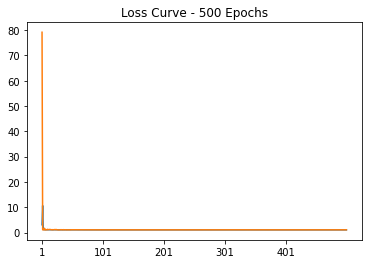

In [309]:
import matplotlib.pyplot as plt
import math
def plot_loss(train_loss_list,val_loss_list):
    epochs_axis=np.arange(len(train_loss_list))+1
    xticks = range(math.floor(min(epochs_axis)), math.ceil(max(epochs_axis))+1,int(len(train_loss_list)/5))
    plt.figure()
    plt.plot(epochs_axis,train_loss_list)
    plt.plot(epochs_axis,val_loss_list)
    plt.title('Loss Curve - {} Epochs'.format(len(epochs_axis)))
    plt.xticks(xticks)
    plt.show()

plot_loss(train_loss_list,val_loss_list)

In [310]:
PATH = './dudi_resnet18_500ep_1e-1lr.pth'
torch.save(model.state_dict(), PATH)
#model.load_state_dict(torch.load(PATH))

In [319]:
#Load test dataset
test_data = CustomImageDataset(test_annotations_file_path,test_dataset_path,preprocess)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [320]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


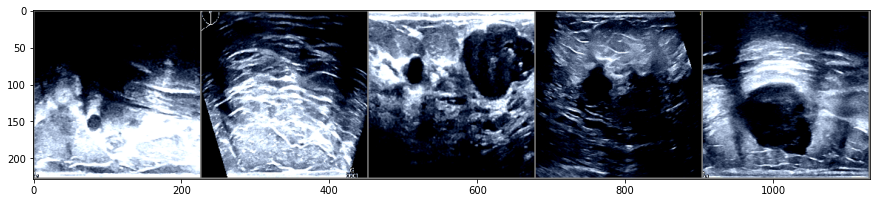

GroundTruth:  benign malignant benign malignant malignant


In [321]:
#Show test images and their label
num_images_to_show=5
imshow(torchvision.utils.make_grid(images[0:num_images_to_show]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images_to_show)))

In [322]:
outputs = model(images)

In [323]:
#Print test images predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

Predicted:  malignant malignant malignant malignant malignant


In [324]:
#Accuracy of total train images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 35 %


In [318]:
#Accuracy of total test images
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 22 %


In [685]:
#Accuracy of train images by class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label-1]] += 1
            total_pred[classes[label-1]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy of train for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of train for class: benign is 89.7 %
Accuracy of train for class: normal is 100.0 %
Accuracy of train for class: malignant is 99.1 %


In [686]:
#Accuracy of test images by class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label-1]] += 1
            total_pred[classes[label-1]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy of test for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of test for class: benign is 61.5 %
Accuracy of test for class: normal is 79.6 %
Accuracy of test for class: malignant is 53.3 %


<AxesSubplot:>

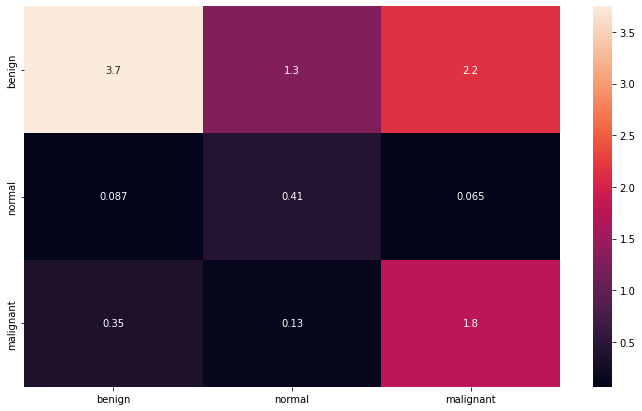

In [687]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        



# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

Intermediate Summary:
Net results are not good enough, it seems from confusion matrix that model is biased to classify to benign label. Here are some possible issues and solutions.

| Possible issue | Possible solution |
| --- | --- |
| Lack of data | Download more data. Change train to test ratio and check again. |
| --- | --- |
| Transform Parameters | Change Resize method. Change normalize value (mean,std.) |
| --- | --- |
| Hyper Parameters | Change learning rate, batch size, loss function, optimizer. |
| --- | --- |
| Classes similarity | Train and test the model for normal and malignant (best and worst case). Without benign (middle case). |











